In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc
from tqdm import tqdm
from backbone1 import DenseNet201
from dataloader import create_dataloader
from metric import Metric
from ctran import CTranEncoder
torch.cuda.empty_cache()

# Set device to GPU if available, else use CPU
device = torch.device("cuda:0")
print(f"Current device: {torch.cuda.get_device_name(torch.cuda.current_device())}" if torch.cuda.is_available() else "Current device: CPU")

Current device: NVIDIA GeForce RTX 2080 Ti


In [2]:
# Define hyperparameters
batch_size = 16
num_epochs = 200
learning_rate = 0.000001
image_size = 384
num_workers = 4
num_labels = 20
thresholds = [0.5] * num_labels
num_classes = 20
data_dir = '../data'

In [3]:
# Create dataloaders
train_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='train')
val_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='val')

384
384


In [4]:
# Define model and optimizer
backbone = DenseNet201(num_classes=num_classes, embed_dim = 960)
model = CTranEncoder(num_classes=num_classes, embed_dim=960, num_layers=6, num_heads=num_workers, backbone=backbone)
model.to(device)

# Wrap your model with DataParallel
model = nn.DataParallel(model)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/home/deependra/project/rfmidc/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/deependra/project/rfmidc/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# Initialize Metric class
metric = Metric(num_classes=num_classes)

# create empty lists to store predicted probabilities and true labels for each epoch
val_preds_all, val_labels_all = [], []

# define the epochs at which to plot the ROC curve
roc_epochs = [5,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200]

# create empty lists to store ROC data for each epoch
roc_fpr = []
roc_tpr = []
roc_auc = []
f1_arr = []
loss_arr = []
model_arr = []
a=0

# Train and evaluate model
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('-' * 10)

    # Train phase
    model.train()
    for images, labels in tqdm(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        loss = criterion(outputs, labels)    
        outputs = torch.sigmoid(outputs)
        if a == 0: 
            print(labels)
            print(outputs)
            a=a+1
        

        # Backward and optimize
        loss.backward()
        optimizer.step()

        # Compute metrics on train set
        with torch.no_grad():
            metric.update(outputs, labels,0)

    # Print metrics on train set
    ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score = metric.compute(1)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")

    # Reset Metric class for evaluation
    metric.reset()

    # Evaluate model on validation set
    model.eval()
    running_loss = 0.0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_dataloader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)

            # Compute metrics on validation set
            outputs = torch.sigmoid(outputs)
            metric.update(outputs, labels,1)
            running_loss += criterion(outputs, labels).item()

            # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
            val_preds += outputs.tolist()
            val_labels += labels.tolist()
 
        # Print metrics on validation set
        ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score = metric.compute(0)
        print(f"Val - Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
        
        f1_arr.append(ml_f1_score)
        model_arr.append(model_score)
        loss_arr.append(running_loss / len(val_dataloader))

        # append the predicted probabilities and true labels for this epoch to the lists for all epochs
        val_preds_all.append(val_preds)
        val_labels_all.append(val_labels)

        # check if the current epoch is in the list of epochs to plot ROC curve
        if epoch+1 in roc_epochs:
            # calculate ROC curve and AUC score for validation set
            fpr, tpr, roc_thresholds = roc_curve(np.concatenate(val_labels_all).ravel(), np.concatenate(val_preds_all).ravel())
            roc_fpr.append(fpr)
            roc_tpr.append(tpr)
            roc_auc.append(auc(fpr, tpr))

        print() # empty line for spacing
        
        # Reset Metric class for next epoch
        metric.reset()
        del images
        del labels
        del outputs
        torch.cuda.empty_cache()        

Epoch 1/200
----------


  0%|          | 0/111 [00:00<?, ?it/s]

tensor([[0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1.],
        [0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0

100%|██████████| 111/111 [02:05<00:00,  1.13s/it]


Epoch [1/200], Loss: 0.3486, ML mAP: 0.0871, ML F1: 0.0542, ML AUC: 0.5204, ML Score: 0.3037, Bin AUC: 0.4510, Model Score: 0.3774, Bin F1: 0.2222


100%|██████████| 28/28 [00:25<00:00,  1.11it/s]


Val - Epoch [1/200], Loss: 0.3486, ML mAP: 0.0941, ML F1: 0.0000, ML AUC: 0.6053, ML Score: 0.3497, Bin AUC: 0.3158, Model Score: 0.3327, Bin F1: 0.0000

Epoch 2/200
----------


100%|██████████| 111/111 [01:50<00:00,  1.01it/s]


Epoch [2/200], Loss: 0.2548, ML mAP: 0.1059, ML F1: 0.0000, ML AUC: 0.5834, ML Score: 0.3447, Bin AUC: 0.7500, Model Score: 0.5473, Bin F1: 0.0000


100%|██████████| 28/28 [00:19<00:00,  1.47it/s]


Val - Epoch [2/200], Loss: 0.2548, ML mAP: 0.1210, ML F1: 0.0000, ML AUC: 0.6643, ML Score: 0.3926, Bin AUC: 0.2632, Model Score: 0.3279, Bin F1: 0.0000

Epoch 3/200
----------


100%|██████████| 111/111 [01:49<00:00,  1.01it/s]


Epoch [3/200], Loss: 0.2587, ML mAP: 0.1312, ML F1: 0.0000, ML AUC: 0.6358, ML Score: 0.3835, Bin AUC: 0.8947, Model Score: 0.6391, Bin F1: 0.0000


100%|██████████| 28/28 [00:18<00:00,  1.48it/s]


Val - Epoch [3/200], Loss: 0.2587, ML mAP: 0.1617, ML F1: 0.0000, ML AUC: 0.7226, ML Score: 0.4421, Bin AUC: 0.1579, Model Score: 0.3000, Bin F1: 0.0000

Epoch 4/200
----------


100%|██████████| 111/111 [01:48<00:00,  1.02it/s]


Epoch [4/200], Loss: 0.2451, ML mAP: 0.1745, ML F1: 0.0000, ML AUC: 0.7009, ML Score: 0.4377, Bin AUC: 0.2105, Model Score: 0.3241, Bin F1: 0.0000


100%|██████████| 28/28 [00:18<00:00,  1.48it/s]


Val - Epoch [4/200], Loss: 0.2451, ML mAP: 0.1772, ML F1: 0.0000, ML AUC: 0.7632, ML Score: 0.4702, Bin AUC: 0.3684, Model Score: 0.4193, Bin F1: 0.0000

Epoch 5/200
----------


100%|██████████| 111/111 [01:49<00:00,  1.01it/s]


Epoch [5/200], Loss: 0.2664, ML mAP: 0.1953, ML F1: 0.0000, ML AUC: 0.7241, ML Score: 0.4597, Bin AUC: 0.6389, Model Score: 0.5493, Bin F1: 0.0000


100%|██████████| 28/28 [00:19<00:00,  1.45it/s]


Val - Epoch [5/200], Loss: 0.2664, ML mAP: 0.2192, ML F1: 0.0000, ML AUC: 0.7850, ML Score: 0.5021, Bin AUC: 0.2632, Model Score: 0.3826, Bin F1: 0.0000

Epoch 6/200
----------


100%|██████████| 111/111 [01:48<00:00,  1.02it/s]


Epoch [6/200], Loss: 0.3209, ML mAP: 0.2173, ML F1: 0.0000, ML AUC: 0.7474, ML Score: 0.4823, Bin AUC: 0.7255, Model Score: 0.6039, Bin F1: 0.0000


100%|██████████| 28/28 [00:19<00:00,  1.44it/s]


Val - Epoch [6/200], Loss: 0.3209, ML mAP: 0.2323, ML F1: 0.0000, ML AUC: 0.8086, ML Score: 0.5205, Bin AUC: 0.4211, Model Score: 0.4708, Bin F1: 0.0000

Epoch 7/200
----------


100%|██████████| 111/111 [01:51<00:00,  1.00s/it]


Epoch [7/200], Loss: 0.2967, ML mAP: 0.2348, ML F1: 0.0027, ML AUC: 0.7607, ML Score: 0.4978, Bin AUC: 0.7778, Model Score: 0.6378, Bin F1: 0.0000


100%|██████████| 28/28 [00:18<00:00,  1.48it/s]


Val - Epoch [7/200], Loss: 0.2967, ML mAP: 0.2577, ML F1: 0.0000, ML AUC: 0.8253, ML Score: 0.5415, Bin AUC: 0.5263, Model Score: 0.5339, Bin F1: 0.0000

Epoch 8/200
----------


100%|██████████| 111/111 [01:49<00:00,  1.02it/s]


Epoch [8/200], Loss: 0.3914, ML mAP: 0.2537, ML F1: 0.0119, ML AUC: 0.7727, ML Score: 0.5132, Bin AUC: 0.8889, Model Score: 0.7010, Bin F1: 0.0000


100%|██████████| 28/28 [00:18<00:00,  1.50it/s]


Val - Epoch [8/200], Loss: 0.3914, ML mAP: 0.2751, ML F1: 0.0000, ML AUC: 0.8342, ML Score: 0.5546, Bin AUC: 0.5263, Model Score: 0.5405, Bin F1: 0.0000

Epoch 9/200
----------


100%|██████████| 111/111 [01:48<00:00,  1.03it/s]


Epoch [9/200], Loss: 0.3012, ML mAP: 0.2592, ML F1: 0.0083, ML AUC: 0.7759, ML Score: 0.5176, Bin AUC: 0.9167, Model Score: 0.7171, Bin F1: 0.0000


100%|██████████| 28/28 [00:19<00:00,  1.42it/s]


Val - Epoch [9/200], Loss: 0.3012, ML mAP: 0.2951, ML F1: 0.0096, ML AUC: 0.8421, ML Score: 0.5686, Bin AUC: 0.5789, Model Score: 0.5738, Bin F1: 0.0000

Epoch 10/200
----------


100%|██████████| 111/111 [01:49<00:00,  1.01it/s]


Epoch [10/200], Loss: 0.3113, ML mAP: 0.2633, ML F1: 0.0164, ML AUC: 0.7899, ML Score: 0.5266, Bin AUC: 0.6842, Model Score: 0.6054, Bin F1: 0.0000


100%|██████████| 28/28 [00:18<00:00,  1.51it/s]


Val - Epoch [10/200], Loss: 0.3113, ML mAP: 0.3007, ML F1: 0.0226, ML AUC: 0.8547, ML Score: 0.5777, Bin AUC: 0.6316, Model Score: 0.6046, Bin F1: 0.0000

Epoch 11/200
----------


100%|██████████| 111/111 [01:50<00:00,  1.00it/s]


Epoch [11/200], Loss: 0.2645, ML mAP: 0.2701, ML F1: 0.0164, ML AUC: 0.7978, ML Score: 0.5339, Bin AUC: 0.6389, Model Score: 0.5864, Bin F1: 0.0000


100%|██████████| 28/28 [00:18<00:00,  1.49it/s]


Val - Epoch [11/200], Loss: 0.2645, ML mAP: 0.3216, ML F1: 0.0337, ML AUC: 0.8578, ML Score: 0.5897, Bin AUC: 0.6842, Model Score: 0.6370, Bin F1: 0.0000

Epoch 12/200
----------


100%|██████████| 111/111 [01:47<00:00,  1.03it/s]


Epoch [12/200], Loss: 0.3343, ML mAP: 0.3117, ML F1: 0.0312, ML AUC: 0.8095, ML Score: 0.5606, Bin AUC: 0.7895, Model Score: 0.6750, Bin F1: 0.0000


100%|██████████| 28/28 [00:19<00:00,  1.47it/s]


Val - Epoch [12/200], Loss: 0.3343, ML mAP: 0.3282, ML F1: 0.0731, ML AUC: 0.8665, ML Score: 0.5974, Bin AUC: 0.7368, Model Score: 0.6671, Bin F1: 0.0000

Epoch 13/200
----------


100%|██████████| 111/111 [01:49<00:00,  1.02it/s]


Epoch [13/200], Loss: 0.2874, ML mAP: 0.3334, ML F1: 0.0497, ML AUC: 0.8219, ML Score: 0.5776, Bin AUC: 0.9474, Model Score: 0.7625, Bin F1: 0.0000


100%|██████████| 28/28 [00:19<00:00,  1.46it/s]


Val - Epoch [13/200], Loss: 0.2874, ML mAP: 0.3382, ML F1: 0.0775, ML AUC: 0.8694, ML Score: 0.6038, Bin AUC: 0.8421, Model Score: 0.7229, Bin F1: 0.0000

Epoch 14/200
----------


100%|██████████| 111/111 [01:47<00:00,  1.03it/s]


Epoch [14/200], Loss: 0.1938, ML mAP: 0.3284, ML F1: 0.0463, ML AUC: 0.8202, ML Score: 0.5743, Bin AUC: 0.9474, Model Score: 0.7608, Bin F1: 0.0000


100%|██████████| 28/28 [00:18<00:00,  1.52it/s]


Val - Epoch [14/200], Loss: 0.1938, ML mAP: 0.3541, ML F1: 0.0966, ML AUC: 0.8743, ML Score: 0.6142, Bin AUC: 0.7368, Model Score: 0.6755, Bin F1: 0.0000

Epoch 15/200
----------


100%|██████████| 111/111 [01:48<00:00,  1.02it/s]


Epoch [15/200], Loss: 0.2961, ML mAP: 0.3400, ML F1: 0.0603, ML AUC: 0.8272, ML Score: 0.5836, Bin AUC: 1.0000, Model Score: 0.7918, Bin F1: 0.5000


100%|██████████| 28/28 [00:19<00:00,  1.47it/s]


Val - Epoch [15/200], Loss: 0.2961, ML mAP: 0.3499, ML F1: 0.1124, ML AUC: 0.8771, ML Score: 0.6135, Bin AUC: 0.6842, Model Score: 0.6489, Bin F1: 0.0000

Epoch 16/200
----------


100%|██████████| 111/111 [01:50<00:00,  1.00it/s]


Epoch [16/200], Loss: 0.3794, ML mAP: 0.3534, ML F1: 0.0678, ML AUC: 0.8291, ML Score: 0.5912, Bin AUC: 0.7368, Model Score: 0.6640, Bin F1: 0.0000


100%|██████████| 28/28 [00:19<00:00,  1.47it/s]


Val - Epoch [16/200], Loss: 0.3794, ML mAP: 0.3582, ML F1: 0.1199, ML AUC: 0.8812, ML Score: 0.6197, Bin AUC: 0.5789, Model Score: 0.5993, Bin F1: 0.0000

Epoch 17/200
----------


100%|██████████| 111/111 [01:50<00:00,  1.00it/s]


Epoch [17/200], Loss: 0.3520, ML mAP: 0.3683, ML F1: 0.0916, ML AUC: 0.8368, ML Score: 0.6026, Bin AUC: 1.0000, Model Score: 0.8013, Bin F1: 0.0000


100%|██████████| 28/28 [00:18<00:00,  1.50it/s]


Val - Epoch [17/200], Loss: 0.3520, ML mAP: 0.3667, ML F1: 0.1422, ML AUC: 0.8809, ML Score: 0.6238, Bin AUC: 0.8947, Model Score: 0.7593, Bin F1: 0.0000

Epoch 18/200
----------


100%|██████████| 111/111 [01:50<00:00,  1.00it/s]


Epoch [18/200], Loss: 0.2613, ML mAP: 0.3632, ML F1: 0.0859, ML AUC: 0.8356, ML Score: 0.5994, Bin AUC: 0.5263, Model Score: 0.5629, Bin F1: 0.0000


100%|██████████| 28/28 [00:18<00:00,  1.48it/s]


Val - Epoch [18/200], Loss: 0.2613, ML mAP: 0.3882, ML F1: 0.1426, ML AUC: 0.8850, ML Score: 0.6366, Bin AUC: 0.7895, Model Score: 0.7130, Bin F1: 0.0000

Epoch 19/200
----------


100%|██████████| 111/111 [01:51<00:00,  1.01s/it]


Epoch [19/200], Loss: 0.2086, ML mAP: 0.3992, ML F1: 0.1031, ML AUC: 0.8516, ML Score: 0.6254, Bin AUC: 0.6842, Model Score: 0.6548, Bin F1: 0.0000


100%|██████████| 28/28 [00:19<00:00,  1.45it/s]


Val - Epoch [19/200], Loss: 0.2086, ML mAP: 0.3929, ML F1: 0.1556, ML AUC: 0.8906, ML Score: 0.6417, Bin AUC: 0.8421, Model Score: 0.7419, Bin F1: 0.0000

Epoch 20/200
----------


100%|██████████| 111/111 [01:51<00:00,  1.00s/it]


Epoch [20/200], Loss: 0.3534, ML mAP: 0.3908, ML F1: 0.1213, ML AUC: 0.8412, ML Score: 0.6160, Bin AUC: 0.8889, Model Score: 0.7524, Bin F1: 0.0000


100%|██████████| 28/28 [00:18<00:00,  1.49it/s]


Val - Epoch [20/200], Loss: 0.3534, ML mAP: 0.3903, ML F1: 0.1698, ML AUC: 0.8903, ML Score: 0.6403, Bin AUC: 0.6842, Model Score: 0.6623, Bin F1: 0.0000

Epoch 21/200
----------


100%|██████████| 111/111 [01:51<00:00,  1.00s/it]


Epoch [21/200], Loss: 0.3843, ML mAP: 0.4033, ML F1: 0.1384, ML AUC: 0.8459, ML Score: 0.6246, Bin AUC: 1.0000, Model Score: 0.8123, Bin F1: 0.0000


100%|██████████| 28/28 [00:19<00:00,  1.46it/s]


Val - Epoch [21/200], Loss: 0.3843, ML mAP: 0.4054, ML F1: 0.1719, ML AUC: 0.8926, ML Score: 0.6490, Bin AUC: 0.6842, Model Score: 0.6666, Bin F1: 0.0000

Epoch 22/200
----------


100%|██████████| 111/111 [01:50<00:00,  1.00it/s]


Epoch [22/200], Loss: 0.3005, ML mAP: 0.4342, ML F1: 0.1592, ML AUC: 0.8575, ML Score: 0.6459, Bin AUC: 0.7895, Model Score: 0.7177, Bin F1: 0.0000


100%|██████████| 28/28 [00:19<00:00,  1.43it/s]


Val - Epoch [22/200], Loss: 0.3005, ML mAP: 0.4121, ML F1: 0.1861, ML AUC: 0.8926, ML Score: 0.6524, Bin AUC: 0.7895, Model Score: 0.7209, Bin F1: 0.0000

Epoch 23/200
----------


100%|██████████| 111/111 [01:52<00:00,  1.01s/it]


Epoch [23/200], Loss: 0.3208, ML mAP: 0.4417, ML F1: 0.1695, ML AUC: 0.8631, ML Score: 0.6524, Bin AUC: 1.0000, Model Score: 0.8262, Bin F1: 0.0000


100%|██████████| 28/28 [00:18<00:00,  1.48it/s]


Val - Epoch [23/200], Loss: 0.3208, ML mAP: 0.4035, ML F1: 0.1761, ML AUC: 0.8927, ML Score: 0.6481, Bin AUC: 0.6842, Model Score: 0.6662, Bin F1: 0.0000

Epoch 24/200
----------


100%|██████████| 111/111 [01:52<00:00,  1.01s/it]


Epoch [24/200], Loss: 0.4197, ML mAP: 0.4415, ML F1: 0.1844, ML AUC: 0.8605, ML Score: 0.6510, Bin AUC: 0.6667, Model Score: 0.6588, Bin F1: 0.0000


100%|██████████| 28/28 [00:18<00:00,  1.48it/s]


Val - Epoch [24/200], Loss: 0.4197, ML mAP: 0.4129, ML F1: 0.2157, ML AUC: 0.8941, ML Score: 0.6535, Bin AUC: 0.7368, Model Score: 0.6952, Bin F1: 0.0000

Epoch 25/200
----------


100%|██████████| 111/111 [01:51<00:00,  1.00s/it]


Epoch [25/200], Loss: 0.4701, ML mAP: 0.4598, ML F1: 0.2052, ML AUC: 0.8610, ML Score: 0.6604, Bin AUC: 0.9474, Model Score: 0.8039, Bin F1: 0.0000


100%|██████████| 28/28 [00:18<00:00,  1.51it/s]


Val - Epoch [25/200], Loss: 0.4701, ML mAP: 0.4242, ML F1: 0.2261, ML AUC: 0.8976, ML Score: 0.6609, Bin AUC: 0.7368, Model Score: 0.6989, Bin F1: 0.0000

Epoch 26/200
----------


100%|██████████| 111/111 [01:51<00:00,  1.01s/it]


Epoch [26/200], Loss: 0.2594, ML mAP: 0.4694, ML F1: 0.2066, ML AUC: 0.8694, ML Score: 0.6694, Bin AUC: 0.9608, Model Score: 0.8151, Bin F1: 0.5000


100%|██████████| 28/28 [00:18<00:00,  1.50it/s]


Val - Epoch [26/200], Loss: 0.2594, ML mAP: 0.4385, ML F1: 0.2514, ML AUC: 0.8978, ML Score: 0.6681, Bin AUC: 0.8947, Model Score: 0.7814, Bin F1: 0.0000

Epoch 27/200
----------


100%|██████████| 111/111 [01:49<00:00,  1.02it/s]


Epoch [27/200], Loss: 0.4578, ML mAP: 0.4755, ML F1: 0.2133, ML AUC: 0.8710, ML Score: 0.6732, Bin AUC: 1.0000, Model Score: 0.8366, Bin F1: 0.0000


100%|██████████| 28/28 [00:19<00:00,  1.44it/s]


Val - Epoch [27/200], Loss: 0.4578, ML mAP: 0.4406, ML F1: 0.2500, ML AUC: 0.8995, ML Score: 0.6701, Bin AUC: 0.9474, Model Score: 0.8087, Bin F1: 0.0000

Epoch 28/200
----------


100%|██████████| 111/111 [01:51<00:00,  1.01s/it]


Epoch [28/200], Loss: 0.3391, ML mAP: 0.4591, ML F1: 0.2282, ML AUC: 0.8717, ML Score: 0.6654, Bin AUC: 1.0000, Model Score: 0.8327, Bin F1: 0.5000


100%|██████████| 28/28 [00:19<00:00,  1.46it/s]


Val - Epoch [28/200], Loss: 0.3391, ML mAP: 0.4314, ML F1: 0.2668, ML AUC: 0.9008, ML Score: 0.6661, Bin AUC: 0.8421, Model Score: 0.7541, Bin F1: 0.0000

Epoch 29/200
----------


100%|██████████| 111/111 [01:51<00:00,  1.00s/it]


Epoch [29/200], Loss: 0.2327, ML mAP: 0.4678, ML F1: 0.2347, ML AUC: 0.8755, ML Score: 0.6717, Bin AUC: 1.0000, Model Score: 0.8358, Bin F1: 0.5000


100%|██████████| 28/28 [00:18<00:00,  1.48it/s]


Val - Epoch [29/200], Loss: 0.2327, ML mAP: 0.4427, ML F1: 0.2564, ML AUC: 0.9000, ML Score: 0.6713, Bin AUC: 0.6842, Model Score: 0.6778, Bin F1: 0.0000

Epoch 30/200
----------


100%|██████████| 111/111 [01:52<00:00,  1.01s/it]


Epoch [30/200], Loss: 0.2957, ML mAP: 0.4930, ML F1: 0.2530, ML AUC: 0.8797, ML Score: 0.6864, Bin AUC: 0.8611, Model Score: 0.7737, Bin F1: 0.0000


100%|██████████| 28/28 [00:18<00:00,  1.52it/s]


Val - Epoch [30/200], Loss: 0.2957, ML mAP: 0.4566, ML F1: 0.2769, ML AUC: 0.9031, ML Score: 0.6798, Bin AUC: 0.7895, Model Score: 0.7347, Bin F1: 0.0000

Epoch 31/200
----------


100%|██████████| 111/111 [01:52<00:00,  1.01s/it]


Epoch [31/200], Loss: 0.3266, ML mAP: 0.4967, ML F1: 0.2647, ML AUC: 0.8751, ML Score: 0.6859, Bin AUC: 1.0000, Model Score: 0.8429, Bin F1: 0.0000


100%|██████████| 28/28 [00:19<00:00,  1.46it/s]


Val - Epoch [31/200], Loss: 0.3266, ML mAP: 0.4522, ML F1: 0.2732, ML AUC: 0.9047, ML Score: 0.6785, Bin AUC: 0.6316, Model Score: 0.6550, Bin F1: 0.0000

Epoch 32/200
----------


100%|██████████| 111/111 [01:50<00:00,  1.00it/s]


Epoch [32/200], Loss: 0.2214, ML mAP: 0.5010, ML F1: 0.2659, ML AUC: 0.8793, ML Score: 0.6902, Bin AUC: 0.5789, Model Score: 0.6346, Bin F1: 0.0000


100%|██████████| 28/28 [00:18<00:00,  1.49it/s]


Val - Epoch [32/200], Loss: 0.2214, ML mAP: 0.4506, ML F1: 0.2561, ML AUC: 0.9036, ML Score: 0.6771, Bin AUC: 0.9474, Model Score: 0.8122, Bin F1: 0.0000

Epoch 33/200
----------


100%|██████████| 111/111 [01:51<00:00,  1.00s/it]


Epoch [33/200], Loss: 0.2686, ML mAP: 0.4893, ML F1: 0.2656, ML AUC: 0.8804, ML Score: 0.6849, Bin AUC: 0.8889, Model Score: 0.7869, Bin F1: 0.0000


100%|██████████| 28/28 [00:19<00:00,  1.47it/s]


Val - Epoch [33/200], Loss: 0.2686, ML mAP: 0.4628, ML F1: 0.2853, ML AUC: 0.9061, ML Score: 0.6845, Bin AUC: 0.6842, Model Score: 0.6843, Bin F1: 0.0000

Epoch 34/200
----------


100%|██████████| 111/111 [01:50<00:00,  1.01it/s]


Epoch [34/200], Loss: 0.2918, ML mAP: 0.5166, ML F1: 0.2696, ML AUC: 0.8850, ML Score: 0.7008, Bin AUC: 1.0000, Model Score: 0.8504, Bin F1: 1.0000


100%|██████████| 28/28 [00:20<00:00,  1.40it/s]


Val - Epoch [34/200], Loss: 0.2918, ML mAP: 0.4706, ML F1: 0.3022, ML AUC: 0.9088, ML Score: 0.6897, Bin AUC: 0.7368, Model Score: 0.7133, Bin F1: 0.0000

Epoch 35/200
----------


100%|██████████| 111/111 [01:50<00:00,  1.01it/s]


Epoch [35/200], Loss: 0.3173, ML mAP: 0.5241, ML F1: 0.2906, ML AUC: 0.8856, ML Score: 0.7048, Bin AUC: 0.9020, Model Score: 0.8034, Bin F1: 0.0000


100%|██████████| 28/28 [00:20<00:00,  1.39it/s]


Val - Epoch [35/200], Loss: 0.3173, ML mAP: 0.4694, ML F1: 0.2990, ML AUC: 0.9105, ML Score: 0.6899, Bin AUC: 0.7368, Model Score: 0.7134, Bin F1: 0.0000

Epoch 36/200
----------


100%|██████████| 111/111 [01:48<00:00,  1.02it/s]


Epoch [36/200], Loss: 0.2556, ML mAP: 0.5417, ML F1: 0.3073, ML AUC: 0.8919, ML Score: 0.7168, Bin AUC: 0.9804, Model Score: 0.8486, Bin F1: 0.5000


100%|██████████| 28/28 [00:18<00:00,  1.50it/s]


Val - Epoch [36/200], Loss: 0.2556, ML mAP: 0.4849, ML F1: 0.3225, ML AUC: 0.9112, ML Score: 0.6981, Bin AUC: 0.8421, Model Score: 0.7701, Bin F1: 0.0000

Epoch 37/200
----------


100%|██████████| 111/111 [01:56<00:00,  1.05s/it]


Epoch [37/200], Loss: 0.3814, ML mAP: 0.5236, ML F1: 0.3066, ML AUC: 0.8915, ML Score: 0.7076, Bin AUC: 1.0000, Model Score: 0.8538, Bin F1: 1.0000


100%|██████████| 28/28 [00:21<00:00,  1.33it/s]


Val - Epoch [37/200], Loss: 0.3814, ML mAP: 0.4577, ML F1: 0.2826, ML AUC: 0.9073, ML Score: 0.6825, Bin AUC: 0.8421, Model Score: 0.7623, Bin F1: 0.0000

Epoch 38/200
----------


100%|██████████| 111/111 [02:00<00:00,  1.08s/it]


Epoch [38/200], Loss: 0.3619, ML mAP: 0.5598, ML F1: 0.3196, ML AUC: 0.8975, ML Score: 0.7286, Bin AUC: 1.0000, Model Score: 0.8643, Bin F1: 0.0000


100%|██████████| 28/28 [00:18<00:00,  1.51it/s]


Val - Epoch [38/200], Loss: 0.3619, ML mAP: 0.4793, ML F1: 0.3054, ML AUC: 0.9096, ML Score: 0.6944, Bin AUC: 0.8947, Model Score: 0.7946, Bin F1: 0.0000

Epoch 39/200
----------


100%|██████████| 111/111 [01:54<00:00,  1.03s/it]


Epoch [39/200], Loss: 0.5570, ML mAP: 0.5347, ML F1: 0.3218, ML AUC: 0.8961, ML Score: 0.7154, Bin AUC: 0.9722, Model Score: 0.8438, Bin F1: 0.6667


100%|██████████| 28/28 [00:19<00:00,  1.42it/s]


Val - Epoch [39/200], Loss: 0.5570, ML mAP: 0.4773, ML F1: 0.3070, ML AUC: 0.9102, ML Score: 0.6938, Bin AUC: 0.8421, Model Score: 0.7679, Bin F1: 0.0000

Epoch 40/200
----------


100%|██████████| 111/111 [01:54<00:00,  1.03s/it]


Epoch [40/200], Loss: 0.2354, ML mAP: 0.5591, ML F1: 0.3573, ML AUC: 0.8998, ML Score: 0.7295, Bin AUC: 0.7500, Model Score: 0.7397, Bin F1: 0.0000


100%|██████████| 28/28 [00:20<00:00,  1.39it/s]


Val - Epoch [40/200], Loss: 0.2354, ML mAP: 0.4913, ML F1: 0.3193, ML AUC: 0.9148, ML Score: 0.7030, Bin AUC: 0.7895, Model Score: 0.7463, Bin F1: 0.0000

Epoch 41/200
----------


100%|██████████| 111/111 [02:04<00:00,  1.12s/it]


Epoch [41/200], Loss: 0.4008, ML mAP: 0.5744, ML F1: 0.3420, ML AUC: 0.9036, ML Score: 0.7390, Bin AUC: 0.9444, Model Score: 0.8417, Bin F1: 0.0000


100%|██████████| 28/28 [00:19<00:00,  1.40it/s]


Val - Epoch [41/200], Loss: 0.4008, ML mAP: 0.4938, ML F1: 0.3207, ML AUC: 0.9159, ML Score: 0.7049, Bin AUC: 0.8421, Model Score: 0.7735, Bin F1: 0.0000

Epoch 42/200
----------


100%|██████████| 111/111 [02:04<00:00,  1.12s/it]


Epoch [42/200], Loss: 0.3094, ML mAP: 0.5480, ML F1: 0.3530, ML AUC: 0.9027, ML Score: 0.7253, Bin AUC: 1.0000, Model Score: 0.8627, Bin F1: 0.6667


100%|██████████| 28/28 [00:19<00:00,  1.42it/s]


Val - Epoch [42/200], Loss: 0.3094, ML mAP: 0.4908, ML F1: 0.3272, ML AUC: 0.9120, ML Score: 0.7014, Bin AUC: 0.8947, Model Score: 0.7981, Bin F1: 0.0000

Epoch 43/200
----------


100%|██████████| 111/111 [02:06<00:00,  1.14s/it]


Epoch [43/200], Loss: 0.2065, ML mAP: 0.5743, ML F1: 0.3670, ML AUC: 0.9003, ML Score: 0.7373, Bin AUC: 1.0000, Model Score: 0.8687, Bin F1: 0.6667


100%|██████████| 28/28 [00:19<00:00,  1.42it/s]


Val - Epoch [43/200], Loss: 0.2065, ML mAP: 0.4876, ML F1: 0.3420, ML AUC: 0.9151, ML Score: 0.7013, Bin AUC: 0.8947, Model Score: 0.7980, Bin F1: 0.0000

Epoch 44/200
----------


100%|██████████| 111/111 [02:05<00:00,  1.13s/it]


Epoch [44/200], Loss: 0.2107, ML mAP: 0.5770, ML F1: 0.3598, ML AUC: 0.9033, ML Score: 0.7402, Bin AUC: 0.8056, Model Score: 0.7729, Bin F1: 0.0000


100%|██████████| 28/28 [00:20<00:00,  1.38it/s]


Val - Epoch [44/200], Loss: 0.2107, ML mAP: 0.5073, ML F1: 0.3228, ML AUC: 0.9152, ML Score: 0.7113, Bin AUC: 0.7895, Model Score: 0.7504, Bin F1: 0.0000

Epoch 45/200
----------


100%|██████████| 111/111 [02:02<00:00,  1.11s/it]


Epoch [45/200], Loss: 0.2670, ML mAP: 0.5733, ML F1: 0.3759, ML AUC: 0.9029, ML Score: 0.7381, Bin AUC: 0.9722, Model Score: 0.8552, Bin F1: 0.0000


100%|██████████| 28/28 [00:19<00:00,  1.41it/s]


Val - Epoch [45/200], Loss: 0.2670, ML mAP: 0.5142, ML F1: 0.3341, ML AUC: 0.9188, ML Score: 0.7165, Bin AUC: 0.7368, Model Score: 0.7267, Bin F1: 0.0000

Epoch 46/200
----------


100%|██████████| 111/111 [01:59<00:00,  1.08s/it]


Epoch [46/200], Loss: 0.3049, ML mAP: 0.5808, ML F1: 0.3811, ML AUC: 0.9111, ML Score: 0.7460, Bin AUC: 0.9167, Model Score: 0.8313, Bin F1: 0.0000


100%|██████████| 28/28 [00:19<00:00,  1.41it/s]


Val - Epoch [46/200], Loss: 0.3049, ML mAP: 0.5084, ML F1: 0.3273, ML AUC: 0.9165, ML Score: 0.7125, Bin AUC: 0.8947, Model Score: 0.8036, Bin F1: 0.0000

Epoch 47/200
----------


100%|██████████| 111/111 [01:56<00:00,  1.05s/it]


Epoch [47/200], Loss: 0.3579, ML mAP: 0.6019, ML F1: 0.4064, ML AUC: 0.9129, ML Score: 0.7574, Bin AUC: 0.9722, Model Score: 0.8648, Bin F1: 0.0000


100%|██████████| 28/28 [00:21<00:00,  1.33it/s]


Val - Epoch [47/200], Loss: 0.3579, ML mAP: 0.5173, ML F1: 0.3460, ML AUC: 0.9182, ML Score: 0.7178, Bin AUC: 0.9474, Model Score: 0.8326, Bin F1: 0.0000

Epoch 48/200
----------


100%|██████████| 111/111 [01:55<00:00,  1.04s/it]


Epoch [48/200], Loss: 0.3510, ML mAP: 0.6117, ML F1: 0.4039, ML AUC: 0.9118, ML Score: 0.7617, Bin AUC: 0.9474, Model Score: 0.8545, Bin F1: 0.0000


100%|██████████| 28/28 [00:19<00:00,  1.43it/s]


Val - Epoch [48/200], Loss: 0.3510, ML mAP: 0.5135, ML F1: 0.3484, ML AUC: 0.9157, ML Score: 0.7146, Bin AUC: 0.7895, Model Score: 0.7520, Bin F1: 0.0000

Epoch 49/200
----------


100%|██████████| 111/111 [01:58<00:00,  1.07s/it]


Epoch [49/200], Loss: 0.2776, ML mAP: 0.6064, ML F1: 0.3986, ML AUC: 0.9119, ML Score: 0.7592, Bin AUC: 1.0000, Model Score: 0.8796, Bin F1: 0.0000


100%|██████████| 28/28 [00:19<00:00,  1.45it/s]


Val - Epoch [49/200], Loss: 0.2776, ML mAP: 0.5190, ML F1: 0.3431, ML AUC: 0.9184, ML Score: 0.7187, Bin AUC: 0.9474, Model Score: 0.8330, Bin F1: 0.0000

Epoch 50/200
----------


100%|██████████| 111/111 [01:58<00:00,  1.07s/it]


Epoch [50/200], Loss: 0.3814, ML mAP: 0.5958, ML F1: 0.4165, ML AUC: 0.9107, ML Score: 0.7533, Bin AUC: 1.0000, Model Score: 0.8766, Bin F1: 1.0000


100%|██████████| 28/28 [00:18<00:00,  1.48it/s]


Val - Epoch [50/200], Loss: 0.3814, ML mAP: 0.5267, ML F1: 0.3355, ML AUC: 0.9202, ML Score: 0.7235, Bin AUC: 0.8947, Model Score: 0.8091, Bin F1: 0.0000

Epoch 51/200
----------


100%|██████████| 111/111 [01:57<00:00,  1.06s/it]


Epoch [51/200], Loss: 0.2329, ML mAP: 0.6128, ML F1: 0.4207, ML AUC: 0.9116, ML Score: 0.7622, Bin AUC: 0.9608, Model Score: 0.8615, Bin F1: 0.0000


100%|██████████| 28/28 [00:19<00:00,  1.43it/s]


Val - Epoch [51/200], Loss: 0.2329, ML mAP: 0.5235, ML F1: 0.3551, ML AUC: 0.9204, ML Score: 0.7220, Bin AUC: 0.9474, Model Score: 0.8347, Bin F1: 0.0000

Epoch 52/200
----------


100%|██████████| 111/111 [01:57<00:00,  1.06s/it]


Epoch [52/200], Loss: 0.2256, ML mAP: 0.6175, ML F1: 0.4113, ML AUC: 0.9185, ML Score: 0.7680, Bin AUC: 1.0000, Model Score: 0.8840, Bin F1: 0.0000


100%|██████████| 28/28 [00:19<00:00,  1.44it/s]


Val - Epoch [52/200], Loss: 0.2256, ML mAP: 0.5326, ML F1: 0.3897, ML AUC: 0.9211, ML Score: 0.7269, Bin AUC: 0.7895, Model Score: 0.7582, Bin F1: 0.0000

Epoch 53/200
----------


100%|██████████| 111/111 [01:58<00:00,  1.07s/it]


Epoch [53/200], Loss: 0.3402, ML mAP: 0.6199, ML F1: 0.4360, ML AUC: 0.9158, ML Score: 0.7679, Bin AUC: 1.0000, Model Score: 0.8839, Bin F1: 0.0000


100%|██████████| 28/28 [00:19<00:00,  1.43it/s]


Val - Epoch [53/200], Loss: 0.3402, ML mAP: 0.5295, ML F1: 0.3561, ML AUC: 0.9206, ML Score: 0.7250, Bin AUC: 0.8421, Model Score: 0.7836, Bin F1: 0.0000

Epoch 54/200
----------


100%|██████████| 111/111 [02:01<00:00,  1.09s/it]


Epoch [54/200], Loss: 0.2543, ML mAP: 0.6484, ML F1: 0.4561, ML AUC: 0.9232, ML Score: 0.7858, Bin AUC: 0.9722, Model Score: 0.8790, Bin F1: 0.6667


100%|██████████| 28/28 [00:19<00:00,  1.46it/s]


Val - Epoch [54/200], Loss: 0.2543, ML mAP: 0.5253, ML F1: 0.3480, ML AUC: 0.9195, ML Score: 0.7224, Bin AUC: 0.9474, Model Score: 0.8349, Bin F1: 0.0000

Epoch 55/200
----------


100%|██████████| 111/111 [01:59<00:00,  1.08s/it]


Epoch [55/200], Loss: 0.3096, ML mAP: 0.6416, ML F1: 0.4478, ML AUC: 0.9189, ML Score: 0.7802, Bin AUC: 0.9722, Model Score: 0.8762, Bin F1: 0.0000


100%|██████████| 28/28 [00:19<00:00,  1.44it/s]


Val - Epoch [55/200], Loss: 0.3096, ML mAP: 0.5318, ML F1: 0.3706, ML AUC: 0.9213, ML Score: 0.7266, Bin AUC: 0.9474, Model Score: 0.8370, Bin F1: 0.0000

Epoch 56/200
----------


100%|██████████| 111/111 [02:00<00:00,  1.09s/it]


Epoch [56/200], Loss: 0.3248, ML mAP: 0.6440, ML F1: 0.4634, ML AUC: 0.9167, ML Score: 0.7803, Bin AUC: 0.8421, Model Score: 0.8112, Bin F1: 0.0000


100%|██████████| 28/28 [00:19<00:00,  1.47it/s]


Val - Epoch [56/200], Loss: 0.3248, ML mAP: 0.5328, ML F1: 0.3672, ML AUC: 0.9200, ML Score: 0.7264, Bin AUC: 0.7368, Model Score: 0.7316, Bin F1: 0.0000

Epoch 57/200
----------


100%|██████████| 111/111 [02:00<00:00,  1.09s/it]


Epoch [57/200], Loss: 0.3151, ML mAP: 0.6466, ML F1: 0.4786, ML AUC: 0.9234, ML Score: 0.7850, Bin AUC: 1.0000, Model Score: 0.8925, Bin F1: 1.0000


100%|██████████| 28/28 [00:19<00:00,  1.44it/s]


Val - Epoch [57/200], Loss: 0.3151, ML mAP: 0.5308, ML F1: 0.3856, ML AUC: 0.9197, ML Score: 0.7252, Bin AUC: 0.9474, Model Score: 0.8363, Bin F1: 0.0000

Epoch 58/200
----------


100%|██████████| 111/111 [01:56<00:00,  1.05s/it]


Epoch [58/200], Loss: 0.2079, ML mAP: 0.6531, ML F1: 0.4688, ML AUC: 0.9232, ML Score: 0.7881, Bin AUC: 1.0000, Model Score: 0.8941, Bin F1: 0.0000


100%|██████████| 28/28 [00:19<00:00,  1.40it/s]


Val - Epoch [58/200], Loss: 0.2079, ML mAP: 0.5346, ML F1: 0.3832, ML AUC: 0.9202, ML Score: 0.7274, Bin AUC: 0.8947, Model Score: 0.8111, Bin F1: 0.0000

Epoch 59/200
----------


100%|██████████| 111/111 [01:57<00:00,  1.06s/it]


Epoch [59/200], Loss: 0.3204, ML mAP: 0.6500, ML F1: 0.4714, ML AUC: 0.9201, ML Score: 0.7851, Bin AUC: 1.0000, Model Score: 0.8925, Bin F1: 0.0000


100%|██████████| 28/28 [00:19<00:00,  1.44it/s]


Val - Epoch [59/200], Loss: 0.3204, ML mAP: 0.5406, ML F1: 0.3804, ML AUC: 0.9218, ML Score: 0.7312, Bin AUC: 0.9474, Model Score: 0.8393, Bin F1: 0.0000

Epoch 60/200
----------


100%|██████████| 111/111 [01:57<00:00,  1.06s/it]


Epoch [60/200], Loss: 0.3610, ML mAP: 0.6702, ML F1: 0.4926, ML AUC: 0.9266, ML Score: 0.7984, Bin AUC: 1.0000, Model Score: 0.8992, Bin F1: 1.0000


100%|██████████| 28/28 [00:19<00:00,  1.43it/s]


Val - Epoch [60/200], Loss: 0.3610, ML mAP: 0.5348, ML F1: 0.3628, ML AUC: 0.9193, ML Score: 0.7270, Bin AUC: 0.9474, Model Score: 0.8372, Bin F1: 0.0000

Epoch 61/200
----------


100%|██████████| 111/111 [01:56<00:00,  1.05s/it]


Epoch [61/200], Loss: 0.2783, ML mAP: 0.6664, ML F1: 0.4879, ML AUC: 0.9271, ML Score: 0.7967, Bin AUC: 1.0000, Model Score: 0.8984, Bin F1: 0.8000


100%|██████████| 28/28 [00:19<00:00,  1.44it/s]


Val - Epoch [61/200], Loss: 0.2783, ML mAP: 0.5500, ML F1: 0.4160, ML AUC: 0.9221, ML Score: 0.7361, Bin AUC: 0.8421, Model Score: 0.7891, Bin F1: 0.0000

Epoch 62/200
----------


100%|██████████| 111/111 [01:58<00:00,  1.06s/it]


Epoch [62/200], Loss: 0.2850, ML mAP: 0.6915, ML F1: 0.5153, ML AUC: 0.9332, ML Score: 0.8123, Bin AUC: 0.7895, Model Score: 0.8009, Bin F1: 0.0000


100%|██████████| 28/28 [00:18<00:00,  1.48it/s]


Val - Epoch [62/200], Loss: 0.2850, ML mAP: 0.5480, ML F1: 0.3969, ML AUC: 0.9245, ML Score: 0.7363, Bin AUC: 0.9474, Model Score: 0.8418, Bin F1: 0.0000

Epoch 63/200
----------


100%|██████████| 111/111 [01:58<00:00,  1.07s/it]


Epoch [63/200], Loss: 0.2687, ML mAP: 0.6694, ML F1: 0.4979, ML AUC: 0.9271, ML Score: 0.7983, Bin AUC: 1.0000, Model Score: 0.8991, Bin F1: 1.0000


100%|██████████| 28/28 [00:19<00:00,  1.46it/s]


Val - Epoch [63/200], Loss: 0.2687, ML mAP: 0.5494, ML F1: 0.3956, ML AUC: 0.9230, ML Score: 0.7362, Bin AUC: 0.8947, Model Score: 0.8155, Bin F1: 0.0000

Epoch 64/200
----------


100%|██████████| 111/111 [02:01<00:00,  1.09s/it]


Epoch [64/200], Loss: 0.2306, ML mAP: 0.6625, ML F1: 0.4976, ML AUC: 0.9249, ML Score: 0.7937, Bin AUC: 0.9722, Model Score: 0.8830, Bin F1: 0.0000


100%|██████████| 28/28 [00:20<00:00,  1.39it/s]


Val - Epoch [64/200], Loss: 0.2306, ML mAP: 0.5497, ML F1: 0.4300, ML AUC: 0.9251, ML Score: 0.7374, Bin AUC: 0.9474, Model Score: 0.8424, Bin F1: 0.0000

Epoch 65/200
----------


100%|██████████| 111/111 [01:58<00:00,  1.07s/it]


Epoch [65/200], Loss: 0.3694, ML mAP: 0.6856, ML F1: 0.5304, ML AUC: 0.9316, ML Score: 0.8086, Bin AUC: 0.8947, Model Score: 0.8517, Bin F1: 0.0000


100%|██████████| 28/28 [00:20<00:00,  1.40it/s]


Val - Epoch [65/200], Loss: 0.3694, ML mAP: 0.5536, ML F1: 0.4087, ML AUC: 0.9212, ML Score: 0.7374, Bin AUC: 0.9474, Model Score: 0.8424, Bin F1: 0.0000

Epoch 66/200
----------


100%|██████████| 111/111 [01:58<00:00,  1.07s/it]


Epoch [66/200], Loss: 0.2522, ML mAP: 0.6814, ML F1: 0.5204, ML AUC: 0.9308, ML Score: 0.8061, Bin AUC: 0.9608, Model Score: 0.8834, Bin F1: 0.5000


100%|██████████| 28/28 [00:18<00:00,  1.48it/s]


Val - Epoch [66/200], Loss: 0.2522, ML mAP: 0.5519, ML F1: 0.4052, ML AUC: 0.9225, ML Score: 0.7372, Bin AUC: 0.9474, Model Score: 0.8423, Bin F1: 0.0000

Epoch 67/200
----------


100%|██████████| 111/111 [01:58<00:00,  1.07s/it]


Epoch [67/200], Loss: 0.3043, ML mAP: 0.6783, ML F1: 0.5208, ML AUC: 0.9333, ML Score: 0.8058, Bin AUC: 0.5789, Model Score: 0.6924, Bin F1: 0.0000


100%|██████████| 28/28 [00:18<00:00,  1.49it/s]


Val - Epoch [67/200], Loss: 0.3043, ML mAP: 0.5521, ML F1: 0.4211, ML AUC: 0.9209, ML Score: 0.7365, Bin AUC: 0.8421, Model Score: 0.7893, Bin F1: 0.0000

Epoch 68/200
----------


100%|██████████| 111/111 [01:51<00:00,  1.01s/it]


Epoch [68/200], Loss: 0.3669, ML mAP: 0.6910, ML F1: 0.5230, ML AUC: 0.9354, ML Score: 0.8132, Bin AUC: 0.9167, Model Score: 0.8649, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.27it/s]


Val - Epoch [68/200], Loss: 0.3669, ML mAP: 0.5543, ML F1: 0.4151, ML AUC: 0.9241, ML Score: 0.7392, Bin AUC: 0.8947, Model Score: 0.8170, Bin F1: 0.0000

Epoch 69/200
----------


100%|██████████| 111/111 [01:12<00:00,  1.54it/s]


Epoch [69/200], Loss: 0.2906, ML mAP: 0.6923, ML F1: 0.5334, ML AUC: 0.9366, ML Score: 0.8145, Bin AUC: 1.0000, Model Score: 0.9072, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.21it/s]


Val - Epoch [69/200], Loss: 0.2906, ML mAP: 0.5626, ML F1: 0.4098, ML AUC: 0.9245, ML Score: 0.7436, Bin AUC: 0.9474, Model Score: 0.8455, Bin F1: 0.0000

Epoch 70/200
----------


100%|██████████| 111/111 [01:12<00:00,  1.53it/s]


Epoch [70/200], Loss: 0.3938, ML mAP: 0.6916, ML F1: 0.5422, ML AUC: 0.9331, ML Score: 0.8124, Bin AUC: 0.9167, Model Score: 0.8645, Bin F1: 0.5000


100%|██████████| 28/28 [00:12<00:00,  2.21it/s]


Val - Epoch [70/200], Loss: 0.3938, ML mAP: 0.5517, ML F1: 0.4088, ML AUC: 0.9240, ML Score: 0.7379, Bin AUC: 0.9474, Model Score: 0.8426, Bin F1: 0.0000

Epoch 71/200
----------


100%|██████████| 111/111 [01:11<00:00,  1.55it/s]


Epoch [71/200], Loss: 0.2861, ML mAP: 0.7051, ML F1: 0.5514, ML AUC: 0.9324, ML Score: 0.8187, Bin AUC: 0.8889, Model Score: 0.8538, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.28it/s]


Val - Epoch [71/200], Loss: 0.2861, ML mAP: 0.5603, ML F1: 0.4052, ML AUC: 0.9220, ML Score: 0.7412, Bin AUC: 0.9474, Model Score: 0.8443, Bin F1: 0.0000

Epoch 72/200
----------


100%|██████████| 111/111 [01:10<00:00,  1.58it/s]


Epoch [72/200], Loss: 0.3641, ML mAP: 0.7072, ML F1: 0.5448, ML AUC: 0.9360, ML Score: 0.8216, Bin AUC: 1.0000, Model Score: 0.9108, Bin F1: 1.0000


100%|██████████| 28/28 [00:13<00:00,  2.13it/s]


Val - Epoch [72/200], Loss: 0.3641, ML mAP: 0.5640, ML F1: 0.4150, ML AUC: 0.9248, ML Score: 0.7444, Bin AUC: 0.8947, Model Score: 0.8196, Bin F1: 0.0000

Epoch 73/200
----------


100%|██████████| 111/111 [01:09<00:00,  1.59it/s]


Epoch [73/200], Loss: 0.2939, ML mAP: 0.7144, ML F1: 0.5512, ML AUC: 0.9379, ML Score: 0.8262, Bin AUC: 0.7778, Model Score: 0.8020, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.21it/s]


Val - Epoch [73/200], Loss: 0.2939, ML mAP: 0.5509, ML F1: 0.3727, ML AUC: 0.9220, ML Score: 0.7364, Bin AUC: 0.9474, Model Score: 0.8419, Bin F1: 0.0000

Epoch 74/200
----------


100%|██████████| 111/111 [01:12<00:00,  1.52it/s]


Epoch [74/200], Loss: 0.2480, ML mAP: 0.7136, ML F1: 0.5560, ML AUC: 0.9395, ML Score: 0.8266, Bin AUC: 1.0000, Model Score: 0.9133, Bin F1: 1.0000


100%|██████████| 28/28 [00:13<00:00,  2.13it/s]


Val - Epoch [74/200], Loss: 0.2480, ML mAP: 0.5569, ML F1: 0.4142, ML AUC: 0.9238, ML Score: 0.7403, Bin AUC: 0.9474, Model Score: 0.8438, Bin F1: 0.0000

Epoch 75/200
----------


100%|██████████| 111/111 [01:09<00:00,  1.59it/s]


Epoch [75/200], Loss: 0.2024, ML mAP: 0.7250, ML F1: 0.5549, ML AUC: 0.9449, ML Score: 0.8350, Bin AUC: 1.0000, Model Score: 0.9175, Bin F1: 0.0000


100%|██████████| 28/28 [00:13<00:00,  2.14it/s]


Val - Epoch [75/200], Loss: 0.2024, ML mAP: 0.5664, ML F1: 0.4026, ML AUC: 0.9238, ML Score: 0.7451, Bin AUC: 0.9474, Model Score: 0.8463, Bin F1: 0.0000

Epoch 76/200
----------


100%|██████████| 111/111 [01:10<00:00,  1.57it/s]


Epoch [76/200], Loss: 0.2642, ML mAP: 0.7101, ML F1: 0.5661, ML AUC: 0.9409, ML Score: 0.8255, Bin AUC: 0.9804, Model Score: 0.9029, Bin F1: 0.6667


100%|██████████| 28/28 [00:12<00:00,  2.23it/s]


Val - Epoch [76/200], Loss: 0.2642, ML mAP: 0.5731, ML F1: 0.4188, ML AUC: 0.9244, ML Score: 0.7488, Bin AUC: 0.9474, Model Score: 0.8481, Bin F1: 0.0000

Epoch 77/200
----------


100%|██████████| 111/111 [01:10<00:00,  1.57it/s]


Epoch [77/200], Loss: 0.2634, ML mAP: 0.7248, ML F1: 0.5697, ML AUC: 0.9427, ML Score: 0.8337, Bin AUC: 0.9444, Model Score: 0.8891, Bin F1: 0.5000


100%|██████████| 28/28 [00:12<00:00,  2.17it/s]


Val - Epoch [77/200], Loss: 0.2634, ML mAP: 0.5738, ML F1: 0.4300, ML AUC: 0.9258, ML Score: 0.7498, Bin AUC: 0.8947, Model Score: 0.8223, Bin F1: 0.0000

Epoch 78/200
----------


100%|██████████| 111/111 [01:10<00:00,  1.57it/s]


Epoch [78/200], Loss: 0.3649, ML mAP: 0.7306, ML F1: 0.5877, ML AUC: 0.9433, ML Score: 0.8370, Bin AUC: 0.9722, Model Score: 0.9046, Bin F1: 0.6667


100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Val - Epoch [78/200], Loss: 0.3649, ML mAP: 0.5655, ML F1: 0.4124, ML AUC: 0.9239, ML Score: 0.7447, Bin AUC: 0.9474, Model Score: 0.8460, Bin F1: 0.0000

Epoch 79/200
----------


100%|██████████| 111/111 [01:10<00:00,  1.57it/s]


Epoch [79/200], Loss: 0.3153, ML mAP: 0.7331, ML F1: 0.5917, ML AUC: 0.9448, ML Score: 0.8390, Bin AUC: 1.0000, Model Score: 0.9195, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.19it/s]


Val - Epoch [79/200], Loss: 0.3153, ML mAP: 0.5663, ML F1: 0.4326, ML AUC: 0.9239, ML Score: 0.7451, Bin AUC: 0.9474, Model Score: 0.8463, Bin F1: 0.0000

Epoch 80/200
----------


100%|██████████| 111/111 [01:11<00:00,  1.55it/s]


Epoch [80/200], Loss: 0.2738, ML mAP: 0.7235, ML F1: 0.5799, ML AUC: 0.9411, ML Score: 0.8323, Bin AUC: 1.0000, Model Score: 0.9161, Bin F1: 1.0000


100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Val - Epoch [80/200], Loss: 0.2738, ML mAP: 0.5740, ML F1: 0.4370, ML AUC: 0.9250, ML Score: 0.7495, Bin AUC: 0.8421, Model Score: 0.7958, Bin F1: 0.0000

Epoch 81/200
----------


100%|██████████| 111/111 [01:12<00:00,  1.53it/s]


Epoch [81/200], Loss: 0.3015, ML mAP: 0.7350, ML F1: 0.5864, ML AUC: 0.9454, ML Score: 0.8402, Bin AUC: 1.0000, Model Score: 0.9201, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.17it/s]


Val - Epoch [81/200], Loss: 0.3015, ML mAP: 0.5714, ML F1: 0.4232, ML AUC: 0.9241, ML Score: 0.7478, Bin AUC: 0.8947, Model Score: 0.8213, Bin F1: 0.0000

Epoch 82/200
----------


100%|██████████| 111/111 [01:11<00:00,  1.55it/s]


Epoch [82/200], Loss: 0.3469, ML mAP: 0.7295, ML F1: 0.5824, ML AUC: 0.9415, ML Score: 0.8355, Bin AUC: 1.0000, Model Score: 0.9178, Bin F1: 0.8000


100%|██████████| 28/28 [00:12<00:00,  2.19it/s]


Val - Epoch [82/200], Loss: 0.3469, ML mAP: 0.5761, ML F1: 0.4260, ML AUC: 0.9233, ML Score: 0.7497, Bin AUC: 0.9474, Model Score: 0.8486, Bin F1: 0.0000

Epoch 83/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [83/200], Loss: 0.2832, ML mAP: 0.7417, ML F1: 0.5947, ML AUC: 0.9455, ML Score: 0.8436, Bin AUC: 1.0000, Model Score: 0.9218, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.30it/s]


Val - Epoch [83/200], Loss: 0.2832, ML mAP: 0.5767, ML F1: 0.4378, ML AUC: 0.9269, ML Score: 0.7518, Bin AUC: 0.9474, Model Score: 0.8496, Bin F1: 0.0000

Epoch 84/200
----------


100%|██████████| 111/111 [01:13<00:00,  1.50it/s]


Epoch [84/200], Loss: 0.3098, ML mAP: 0.7542, ML F1: 0.6156, ML AUC: 0.9466, ML Score: 0.8504, Bin AUC: 1.0000, Model Score: 0.9252, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.24it/s]


Val - Epoch [84/200], Loss: 0.3098, ML mAP: 0.5729, ML F1: 0.4388, ML AUC: 0.9252, ML Score: 0.7491, Bin AUC: 0.9474, Model Score: 0.8482, Bin F1: 0.0000

Epoch 85/200
----------


100%|██████████| 111/111 [01:13<00:00,  1.51it/s]


Epoch [85/200], Loss: 0.2417, ML mAP: 0.7479, ML F1: 0.6143, ML AUC: 0.9470, ML Score: 0.8474, Bin AUC: 1.0000, Model Score: 0.9237, Bin F1: 1.0000


100%|██████████| 28/28 [00:13<00:00,  2.15it/s]


Val - Epoch [85/200], Loss: 0.2417, ML mAP: 0.5836, ML F1: 0.4428, ML AUC: 0.9246, ML Score: 0.7541, Bin AUC: 0.8421, Model Score: 0.7981, Bin F1: 0.0000

Epoch 86/200
----------


100%|██████████| 111/111 [01:10<00:00,  1.58it/s]


Epoch [86/200], Loss: 0.2541, ML mAP: 0.7452, ML F1: 0.6171, ML AUC: 0.9440, ML Score: 0.8446, Bin AUC: 0.9804, Model Score: 0.9125, Bin F1: 0.5000


100%|██████████| 28/28 [00:12<00:00,  2.16it/s]


Val - Epoch [86/200], Loss: 0.2541, ML mAP: 0.5788, ML F1: 0.4365, ML AUC: 0.9249, ML Score: 0.7519, Bin AUC: 0.9474, Model Score: 0.8496, Bin F1: 0.0000

Epoch 87/200
----------


100%|██████████| 111/111 [01:11<00:00,  1.55it/s]


Epoch [87/200], Loss: 0.2304, ML mAP: 0.7569, ML F1: 0.6339, ML AUC: 0.9481, ML Score: 0.8525, Bin AUC: 0.8824, Model Score: 0.8674, Bin F1: 0.3333


100%|██████████| 28/28 [00:13<00:00,  2.15it/s]


Val - Epoch [87/200], Loss: 0.2304, ML mAP: 0.5753, ML F1: 0.4379, ML AUC: 0.9237, ML Score: 0.7495, Bin AUC: 0.9474, Model Score: 0.8484, Bin F1: 0.0000

Epoch 88/200
----------


100%|██████████| 111/111 [01:13<00:00,  1.51it/s]


Epoch [88/200], Loss: 0.4683, ML mAP: 0.7546, ML F1: 0.6135, ML AUC: 0.9489, ML Score: 0.8517, Bin AUC: 0.9804, Model Score: 0.9161, Bin F1: 0.5000


100%|██████████| 28/28 [00:13<00:00,  2.12it/s]


Val - Epoch [88/200], Loss: 0.4683, ML mAP: 0.5756, ML F1: 0.4679, ML AUC: 0.9243, ML Score: 0.7500, Bin AUC: 0.8947, Model Score: 0.8224, Bin F1: 0.0000

Epoch 89/200
----------


100%|██████████| 111/111 [01:11<00:00,  1.55it/s]


Epoch [89/200], Loss: 0.2602, ML mAP: 0.7650, ML F1: 0.6263, ML AUC: 0.9493, ML Score: 0.8571, Bin AUC: 1.0000, Model Score: 0.9286, Bin F1: 1.0000


100%|██████████| 28/28 [00:13<00:00,  2.13it/s]


Val - Epoch [89/200], Loss: 0.2602, ML mAP: 0.5808, ML F1: 0.4702, ML AUC: 0.9263, ML Score: 0.7535, Bin AUC: 0.9474, Model Score: 0.8505, Bin F1: 0.0000

Epoch 90/200
----------


100%|██████████| 111/111 [01:09<00:00,  1.60it/s]


Epoch [90/200], Loss: 0.2914, ML mAP: 0.7576, ML F1: 0.6174, ML AUC: 0.9470, ML Score: 0.8523, Bin AUC: 1.0000, Model Score: 0.9262, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.23it/s]


Val - Epoch [90/200], Loss: 0.2914, ML mAP: 0.5860, ML F1: 0.4620, ML AUC: 0.9257, ML Score: 0.7559, Bin AUC: 0.9474, Model Score: 0.8516, Bin F1: 0.0000

Epoch 91/200
----------


100%|██████████| 111/111 [01:10<00:00,  1.57it/s]


Epoch [91/200], Loss: 0.3254, ML mAP: 0.7764, ML F1: 0.6581, ML AUC: 0.9498, ML Score: 0.8631, Bin AUC: 1.0000, Model Score: 0.9315, Bin F1: 0.0000


100%|██████████| 28/28 [00:13<00:00,  2.11it/s]


Val - Epoch [91/200], Loss: 0.3254, ML mAP: 0.5859, ML F1: 0.4677, ML AUC: 0.9279, ML Score: 0.7569, Bin AUC: 0.9474, Model Score: 0.8521, Bin F1: 0.0000

Epoch 92/200
----------


100%|██████████| 111/111 [01:11<00:00,  1.54it/s]


Epoch [92/200], Loss: 0.2868, ML mAP: 0.7738, ML F1: 0.6408, ML AUC: 0.9523, ML Score: 0.8631, Bin AUC: 0.5263, Model Score: 0.6947, Bin F1: 0.0000


100%|██████████| 28/28 [00:13<00:00,  2.11it/s]


Val - Epoch [92/200], Loss: 0.2868, ML mAP: 0.5890, ML F1: 0.4805, ML AUC: 0.9306, ML Score: 0.7598, Bin AUC: 0.8421, Model Score: 0.8010, Bin F1: 0.0000

Epoch 93/200
----------


100%|██████████| 111/111 [01:12<00:00,  1.53it/s]


Epoch [93/200], Loss: 0.2888, ML mAP: 0.7650, ML F1: 0.6415, ML AUC: 0.9506, ML Score: 0.8578, Bin AUC: 0.9608, Model Score: 0.9093, Bin F1: 0.8000


100%|██████████| 28/28 [00:13<00:00,  2.13it/s]


Val - Epoch [93/200], Loss: 0.2888, ML mAP: 0.5881, ML F1: 0.4507, ML AUC: 0.9275, ML Score: 0.7578, Bin AUC: 0.8947, Model Score: 0.8263, Bin F1: 0.0000

Epoch 94/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.50it/s]


Epoch [94/200], Loss: 0.2483, ML mAP: 0.7675, ML F1: 0.6422, ML AUC: 0.9502, ML Score: 0.8588, Bin AUC: 1.0000, Model Score: 0.9294, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.24it/s]


Val - Epoch [94/200], Loss: 0.2483, ML mAP: 0.5841, ML F1: 0.4668, ML AUC: 0.9250, ML Score: 0.7546, Bin AUC: 0.9474, Model Score: 0.8510, Bin F1: 0.0000

Epoch 95/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [95/200], Loss: 0.3194, ML mAP: 0.7567, ML F1: 0.6357, ML AUC: 0.9464, ML Score: 0.8516, Bin AUC: 1.0000, Model Score: 0.9258, Bin F1: 0.8000


100%|██████████| 28/28 [00:13<00:00,  2.12it/s]


Val - Epoch [95/200], Loss: 0.3194, ML mAP: 0.5808, ML F1: 0.4583, ML AUC: 0.9268, ML Score: 0.7538, Bin AUC: 0.8947, Model Score: 0.8243, Bin F1: 0.0000

Epoch 96/200
----------


100%|██████████| 111/111 [01:11<00:00,  1.55it/s]


Epoch [96/200], Loss: 0.2886, ML mAP: 0.7817, ML F1: 0.6559, ML AUC: 0.9557, ML Score: 0.8687, Bin AUC: 0.7368, Model Score: 0.8027, Bin F1: 0.0000


100%|██████████| 28/28 [00:13<00:00,  2.13it/s]


Val - Epoch [96/200], Loss: 0.2886, ML mAP: 0.5924, ML F1: 0.4556, ML AUC: 0.9283, ML Score: 0.7603, Bin AUC: 0.9474, Model Score: 0.8539, Bin F1: 0.0000

Epoch 97/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.47it/s]


Epoch [97/200], Loss: 0.3231, ML mAP: 0.7752, ML F1: 0.6550, ML AUC: 0.9521, ML Score: 0.8636, Bin AUC: 0.9216, Model Score: 0.8926, Bin F1: 0.4000


100%|██████████| 28/28 [00:12<00:00,  2.16it/s]


Val - Epoch [97/200], Loss: 0.3231, ML mAP: 0.5823, ML F1: 0.4728, ML AUC: 0.9285, ML Score: 0.7554, Bin AUC: 0.9474, Model Score: 0.8514, Bin F1: 0.0000

Epoch 98/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [98/200], Loss: 0.2428, ML mAP: 0.7925, ML F1: 0.6710, ML AUC: 0.9572, ML Score: 0.8749, Bin AUC: 1.0000, Model Score: 0.9374, Bin F1: 1.0000


100%|██████████| 28/28 [00:13<00:00,  2.13it/s]


Val - Epoch [98/200], Loss: 0.2428, ML mAP: 0.5784, ML F1: 0.4381, ML AUC: 0.9281, ML Score: 0.7533, Bin AUC: 0.9474, Model Score: 0.8503, Bin F1: 0.0000

Epoch 99/200
----------


100%|██████████| 111/111 [01:11<00:00,  1.55it/s]


Epoch [99/200], Loss: 0.2506, ML mAP: 0.7770, ML F1: 0.6510, ML AUC: 0.9532, ML Score: 0.8651, Bin AUC: 0.9474, Model Score: 0.9062, Bin F1: 0.0000


100%|██████████| 28/28 [00:13<00:00,  2.10it/s]


Val - Epoch [99/200], Loss: 0.2506, ML mAP: 0.5860, ML F1: 0.4695, ML AUC: 0.9285, ML Score: 0.7573, Bin AUC: 0.9474, Model Score: 0.8523, Bin F1: 0.0000

Epoch 100/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [100/200], Loss: 0.2932, ML mAP: 0.7846, ML F1: 0.6651, ML AUC: 0.9531, ML Score: 0.8688, Bin AUC: 1.0000, Model Score: 0.9344, Bin F1: 0.0000


100%|██████████| 28/28 [00:13<00:00,  2.15it/s]


Val - Epoch [100/200], Loss: 0.2932, ML mAP: 0.5830, ML F1: 0.4810, ML AUC: 0.9268, ML Score: 0.7549, Bin AUC: 0.9474, Model Score: 0.8511, Bin F1: 0.0000

Epoch 101/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [101/200], Loss: 0.2938, ML mAP: 0.7870, ML F1: 0.6691, ML AUC: 0.9543, ML Score: 0.8706, Bin AUC: 1.0000, Model Score: 0.9353, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.25it/s]


Val - Epoch [101/200], Loss: 0.2938, ML mAP: 0.5854, ML F1: 0.4770, ML AUC: 0.9283, ML Score: 0.7569, Bin AUC: 0.9474, Model Score: 0.8521, Bin F1: 0.0000

Epoch 102/200
----------


100%|██████████| 111/111 [01:12<00:00,  1.52it/s]


Epoch [102/200], Loss: 0.2355, ML mAP: 0.7858, ML F1: 0.6621, ML AUC: 0.9541, ML Score: 0.8700, Bin AUC: 0.9722, Model Score: 0.9211, Bin F1: 0.5000


100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Val - Epoch [102/200], Loss: 0.2355, ML mAP: 0.5821, ML F1: 0.4651, ML AUC: 0.9272, ML Score: 0.7547, Bin AUC: 0.9474, Model Score: 0.8510, Bin F1: 0.0000

Epoch 103/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.50it/s]


Epoch [103/200], Loss: 0.2791, ML mAP: 0.7983, ML F1: 0.6703, ML AUC: 0.9587, ML Score: 0.8785, Bin AUC: 1.0000, Model Score: 0.9393, Bin F1: 1.0000


100%|██████████| 28/28 [00:13<00:00,  2.10it/s]


Val - Epoch [103/200], Loss: 0.2791, ML mAP: 0.5852, ML F1: 0.5026, ML AUC: 0.9255, ML Score: 0.7554, Bin AUC: 0.9474, Model Score: 0.8514, Bin F1: 0.0000

Epoch 104/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [104/200], Loss: 0.2413, ML mAP: 0.7914, ML F1: 0.6752, ML AUC: 0.9559, ML Score: 0.8737, Bin AUC: 1.0000, Model Score: 0.9368, Bin F1: 1.0000


100%|██████████| 28/28 [00:13<00:00,  2.10it/s]


Val - Epoch [104/200], Loss: 0.2413, ML mAP: 0.5913, ML F1: 0.4634, ML AUC: 0.9283, ML Score: 0.7598, Bin AUC: 0.8947, Model Score: 0.8273, Bin F1: 0.0000

Epoch 105/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [105/200], Loss: 0.3176, ML mAP: 0.7976, ML F1: 0.6715, ML AUC: 0.9591, ML Score: 0.8784, Bin AUC: 0.9444, Model Score: 0.9114, Bin F1: 0.5000


100%|██████████| 28/28 [00:12<00:00,  2.19it/s]


Val - Epoch [105/200], Loss: 0.3176, ML mAP: 0.5875, ML F1: 0.4641, ML AUC: 0.9294, ML Score: 0.7584, Bin AUC: 0.9474, Model Score: 0.8529, Bin F1: 0.0000

Epoch 106/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.47it/s]


Epoch [106/200], Loss: 0.3177, ML mAP: 0.7929, ML F1: 0.6801, ML AUC: 0.9559, ML Score: 0.8744, Bin AUC: 1.0000, Model Score: 0.9372, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.19it/s]


Val - Epoch [106/200], Loss: 0.3177, ML mAP: 0.5947, ML F1: 0.4769, ML AUC: 0.9268, ML Score: 0.7607, Bin AUC: 0.9474, Model Score: 0.8541, Bin F1: 0.0000

Epoch 107/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [107/200], Loss: 0.2905, ML mAP: 0.7979, ML F1: 0.6870, ML AUC: 0.9570, ML Score: 0.8774, Bin AUC: 1.0000, Model Score: 0.9387, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.21it/s]


Val - Epoch [107/200], Loss: 0.2905, ML mAP: 0.5905, ML F1: 0.4784, ML AUC: 0.9291, ML Score: 0.7598, Bin AUC: 0.9474, Model Score: 0.8536, Bin F1: 0.0000

Epoch 108/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [108/200], Loss: 0.3196, ML mAP: 0.8091, ML F1: 0.6951, ML AUC: 0.9610, ML Score: 0.8851, Bin AUC: 1.0000, Model Score: 0.9425, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.19it/s]


Val - Epoch [108/200], Loss: 0.3196, ML mAP: 0.6015, ML F1: 0.4832, ML AUC: 0.9303, ML Score: 0.7659, Bin AUC: 0.8421, Model Score: 0.8040, Bin F1: 0.0000

Epoch 109/200
----------


100%|██████████| 111/111 [01:12<00:00,  1.53it/s]


Epoch [109/200], Loss: 0.3591, ML mAP: 0.7966, ML F1: 0.6870, ML AUC: 0.9566, ML Score: 0.8766, Bin AUC: 0.8947, Model Score: 0.8857, Bin F1: 0.5000


100%|██████████| 28/28 [00:12<00:00,  2.18it/s]


Val - Epoch [109/200], Loss: 0.3591, ML mAP: 0.5876, ML F1: 0.4914, ML AUC: 0.9294, ML Score: 0.7585, Bin AUC: 0.9474, Model Score: 0.8529, Bin F1: 0.0000

Epoch 110/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [110/200], Loss: 0.2264, ML mAP: 0.8096, ML F1: 0.6954, ML AUC: 0.9616, ML Score: 0.8856, Bin AUC: 0.9474, Model Score: 0.9165, Bin F1: 0.0000


100%|██████████| 28/28 [00:13<00:00,  2.13it/s]


Val - Epoch [110/200], Loss: 0.2264, ML mAP: 0.5931, ML F1: 0.4883, ML AUC: 0.9310, ML Score: 0.7620, Bin AUC: 0.9474, Model Score: 0.8547, Bin F1: 0.0000

Epoch 111/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [111/200], Loss: 0.1920, ML mAP: 0.8162, ML F1: 0.7044, ML AUC: 0.9591, ML Score: 0.8876, Bin AUC: 1.0000, Model Score: 0.9438, Bin F1: 0.0000


100%|██████████| 28/28 [00:13<00:00,  2.11it/s]


Val - Epoch [111/200], Loss: 0.1920, ML mAP: 0.5989, ML F1: 0.4805, ML AUC: 0.9291, ML Score: 0.7640, Bin AUC: 0.9474, Model Score: 0.8557, Bin F1: 0.0000

Epoch 112/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [112/200], Loss: 0.3003, ML mAP: 0.7953, ML F1: 0.6927, ML AUC: 0.9590, ML Score: 0.8771, Bin AUC: 0.9444, Model Score: 0.9108, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.27it/s]


Val - Epoch [112/200], Loss: 0.3003, ML mAP: 0.5909, ML F1: 0.5018, ML AUC: 0.9308, ML Score: 0.7609, Bin AUC: 0.9474, Model Score: 0.8541, Bin F1: 0.0000

Epoch 113/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [113/200], Loss: 0.2617, ML mAP: 0.8103, ML F1: 0.7036, ML AUC: 0.9601, ML Score: 0.8852, Bin AUC: 1.0000, Model Score: 0.9426, Bin F1: 1.0000


100%|██████████| 28/28 [00:13<00:00,  2.12it/s]


Val - Epoch [113/200], Loss: 0.2617, ML mAP: 0.5877, ML F1: 0.4973, ML AUC: 0.9277, ML Score: 0.7577, Bin AUC: 0.9474, Model Score: 0.8525, Bin F1: 0.0000

Epoch 114/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [114/200], Loss: 0.2132, ML mAP: 0.8006, ML F1: 0.6862, ML AUC: 0.9582, ML Score: 0.8794, Bin AUC: 0.7368, Model Score: 0.8081, Bin F1: 0.0000


100%|██████████| 28/28 [00:13<00:00,  2.10it/s]


Val - Epoch [114/200], Loss: 0.2132, ML mAP: 0.5903, ML F1: 0.4954, ML AUC: 0.9278, ML Score: 0.7590, Bin AUC: 0.9474, Model Score: 0.8532, Bin F1: 0.0000

Epoch 115/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [115/200], Loss: 0.2370, ML mAP: 0.8034, ML F1: 0.7016, ML AUC: 0.9600, ML Score: 0.8817, Bin AUC: 1.0000, Model Score: 0.9408, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.19it/s]


Val - Epoch [115/200], Loss: 0.2370, ML mAP: 0.6004, ML F1: 0.4938, ML AUC: 0.9270, ML Score: 0.7637, Bin AUC: 0.9474, Model Score: 0.8556, Bin F1: 0.0000

Epoch 116/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.50it/s]


Epoch [116/200], Loss: 0.2991, ML mAP: 0.8160, ML F1: 0.7041, ML AUC: 0.9644, ML Score: 0.8902, Bin AUC: 1.0000, Model Score: 0.9451, Bin F1: 1.0000


100%|██████████| 28/28 [00:13<00:00,  2.13it/s]


Val - Epoch [116/200], Loss: 0.2991, ML mAP: 0.5900, ML F1: 0.4858, ML AUC: 0.9284, ML Score: 0.7592, Bin AUC: 0.9474, Model Score: 0.8533, Bin F1: 0.0000

Epoch 117/200
----------


100%|██████████| 111/111 [01:12<00:00,  1.52it/s]


Epoch [117/200], Loss: 0.3807, ML mAP: 0.8159, ML F1: 0.7106, ML AUC: 0.9632, ML Score: 0.8895, Bin AUC: 0.8333, Model Score: 0.8614, Bin F1: 0.6667


100%|██████████| 28/28 [00:13<00:00,  2.15it/s]


Val - Epoch [117/200], Loss: 0.3807, ML mAP: 0.6010, ML F1: 0.4831, ML AUC: 0.9310, ML Score: 0.7660, Bin AUC: 0.9474, Model Score: 0.8567, Bin F1: 0.0000

Epoch 118/200
----------


100%|██████████| 111/111 [01:13<00:00,  1.51it/s]


Epoch [118/200], Loss: 0.3513, ML mAP: 0.8149, ML F1: 0.7104, ML AUC: 0.9600, ML Score: 0.8875, Bin AUC: 1.0000, Model Score: 0.9437, Bin F1: 1.0000


100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Val - Epoch [118/200], Loss: 0.3513, ML mAP: 0.6073, ML F1: 0.4925, ML AUC: 0.9267, ML Score: 0.7670, Bin AUC: 0.9474, Model Score: 0.8572, Bin F1: 0.0000

Epoch 119/200
----------


100%|██████████| 111/111 [01:10<00:00,  1.58it/s]


Epoch [119/200], Loss: 0.3084, ML mAP: 0.8258, ML F1: 0.7152, ML AUC: 0.9624, ML Score: 0.8941, Bin AUC: 1.0000, Model Score: 0.9470, Bin F1: 1.0000


100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Val - Epoch [119/200], Loss: 0.3084, ML mAP: 0.6051, ML F1: 0.4978, ML AUC: 0.9305, ML Score: 0.7678, Bin AUC: 0.9474, Model Score: 0.8576, Bin F1: 0.0000

Epoch 120/200
----------


100%|██████████| 111/111 [01:13<00:00,  1.50it/s]


Epoch [120/200], Loss: 0.2338, ML mAP: 0.8160, ML F1: 0.7099, ML AUC: 0.9638, ML Score: 0.8899, Bin AUC: 0.9722, Model Score: 0.9311, Bin F1: 0.5000


100%|██████████| 28/28 [00:13<00:00,  2.11it/s]


Val - Epoch [120/200], Loss: 0.2338, ML mAP: 0.5993, ML F1: 0.4938, ML AUC: 0.9297, ML Score: 0.7645, Bin AUC: 0.9474, Model Score: 0.8559, Bin F1: 0.0000

Epoch 121/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.47it/s]


Epoch [121/200], Loss: 0.2484, ML mAP: 0.8093, ML F1: 0.7112, ML AUC: 0.9605, ML Score: 0.8849, Bin AUC: 1.0000, Model Score: 0.9425, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.16it/s]


Val - Epoch [121/200], Loss: 0.2484, ML mAP: 0.6022, ML F1: 0.4949, ML AUC: 0.9286, ML Score: 0.7654, Bin AUC: 0.9474, Model Score: 0.8564, Bin F1: 0.0000

Epoch 122/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.47it/s]


Epoch [122/200], Loss: 0.3125, ML mAP: 0.8239, ML F1: 0.7209, ML AUC: 0.9611, ML Score: 0.8925, Bin AUC: 0.8056, Model Score: 0.8490, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.27it/s]


Val - Epoch [122/200], Loss: 0.3125, ML mAP: 0.6041, ML F1: 0.5124, ML AUC: 0.9287, ML Score: 0.7664, Bin AUC: 0.9474, Model Score: 0.8569, Bin F1: 0.0000

Epoch 123/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [123/200], Loss: 0.1758, ML mAP: 0.8157, ML F1: 0.7222, ML AUC: 0.9632, ML Score: 0.8895, Bin AUC: 1.0000, Model Score: 0.9447, Bin F1: 1.0000


100%|██████████| 28/28 [00:13<00:00,  2.15it/s]


Val - Epoch [123/200], Loss: 0.1758, ML mAP: 0.6062, ML F1: 0.4960, ML AUC: 0.9302, ML Score: 0.7682, Bin AUC: 0.9474, Model Score: 0.8578, Bin F1: 0.0000

Epoch 124/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [124/200], Loss: 0.2153, ML mAP: 0.8293, ML F1: 0.7293, ML AUC: 0.9643, ML Score: 0.8968, Bin AUC: 0.6842, Model Score: 0.7905, Bin F1: 0.0000


100%|██████████| 28/28 [00:13<00:00,  2.14it/s]


Val - Epoch [124/200], Loss: 0.2153, ML mAP: 0.5934, ML F1: 0.5013, ML AUC: 0.9307, ML Score: 0.7620, Bin AUC: 0.8947, Model Score: 0.8284, Bin F1: 0.0000

Epoch 125/200
----------


100%|██████████| 111/111 [01:13<00:00,  1.52it/s]


Epoch [125/200], Loss: 0.1848, ML mAP: 0.8296, ML F1: 0.7266, ML AUC: 0.9648, ML Score: 0.8972, Bin AUC: 0.9722, Model Score: 0.9347, Bin F1: 0.6667


100%|██████████| 28/28 [00:13<00:00,  2.15it/s]


Val - Epoch [125/200], Loss: 0.1848, ML mAP: 0.5881, ML F1: 0.5027, ML AUC: 0.9276, ML Score: 0.7578, Bin AUC: 0.9474, Model Score: 0.8526, Bin F1: 0.0000

Epoch 126/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.46it/s]


Epoch [126/200], Loss: 0.2611, ML mAP: 0.8198, ML F1: 0.7202, ML AUC: 0.9621, ML Score: 0.8909, Bin AUC: 1.0000, Model Score: 0.9455, Bin F1: 0.6667


100%|██████████| 28/28 [00:12<00:00,  2.24it/s]


Val - Epoch [126/200], Loss: 0.2611, ML mAP: 0.5909, ML F1: 0.4946, ML AUC: 0.9278, ML Score: 0.7594, Bin AUC: 0.9474, Model Score: 0.8534, Bin F1: 0.0000

Epoch 127/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.47it/s]


Epoch [127/200], Loss: 0.2806, ML mAP: 0.8232, ML F1: 0.7299, ML AUC: 0.9641, ML Score: 0.8937, Bin AUC: 1.0000, Model Score: 0.9468, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.20it/s]


Val - Epoch [127/200], Loss: 0.2806, ML mAP: 0.5924, ML F1: 0.4378, ML AUC: 0.9263, ML Score: 0.7594, Bin AUC: 0.9474, Model Score: 0.8534, Bin F1: 0.0000

Epoch 128/200
----------


100%|██████████| 111/111 [01:13<00:00,  1.51it/s]


Epoch [128/200], Loss: 0.3529, ML mAP: 0.8321, ML F1: 0.7367, ML AUC: 0.9654, ML Score: 0.8987, Bin AUC: 0.4167, Model Score: 0.6577, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.19it/s]


Val - Epoch [128/200], Loss: 0.3529, ML mAP: 0.6071, ML F1: 0.4849, ML AUC: 0.9304, ML Score: 0.7687, Bin AUC: 0.9474, Model Score: 0.8581, Bin F1: 0.0000

Epoch 129/200
----------


100%|██████████| 111/111 [01:13<00:00,  1.51it/s]


Epoch [129/200], Loss: 0.2237, ML mAP: 0.8195, ML F1: 0.7211, ML AUC: 0.9627, ML Score: 0.8911, Bin AUC: 0.8947, Model Score: 0.8929, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.16it/s]


Val - Epoch [129/200], Loss: 0.2237, ML mAP: 0.6046, ML F1: 0.5088, ML AUC: 0.9302, ML Score: 0.7674, Bin AUC: 0.8947, Model Score: 0.8311, Bin F1: 0.0000

Epoch 130/200
----------


100%|██████████| 111/111 [01:16<00:00,  1.45it/s]


Epoch [130/200], Loss: 0.2708, ML mAP: 0.8433, ML F1: 0.7461, ML AUC: 0.9702, ML Score: 0.9068, Bin AUC: 1.0000, Model Score: 0.9534, Bin F1: 0.6667


100%|██████████| 28/28 [00:12<00:00,  2.17it/s]


Val - Epoch [130/200], Loss: 0.2708, ML mAP: 0.5929, ML F1: 0.4978, ML AUC: 0.9245, ML Score: 0.7587, Bin AUC: 0.8947, Model Score: 0.8267, Bin F1: 0.0000

Epoch 131/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.47it/s]


Epoch [131/200], Loss: 0.2542, ML mAP: 0.8383, ML F1: 0.7363, ML AUC: 0.9675, ML Score: 0.9029, Bin AUC: 0.6842, Model Score: 0.7936, Bin F1: 0.0000


100%|██████████| 28/28 [00:13<00:00,  2.12it/s]


Val - Epoch [131/200], Loss: 0.2542, ML mAP: 0.6009, ML F1: 0.5103, ML AUC: 0.9290, ML Score: 0.7650, Bin AUC: 0.9474, Model Score: 0.8562, Bin F1: 0.0000

Epoch 132/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [132/200], Loss: 0.3076, ML mAP: 0.8404, ML F1: 0.7453, ML AUC: 0.9688, ML Score: 0.9046, Bin AUC: 0.9474, Model Score: 0.9260, Bin F1: 0.0000


100%|██████████| 28/28 [00:13<00:00,  2.13it/s]


Val - Epoch [132/200], Loss: 0.3076, ML mAP: 0.5957, ML F1: 0.4918, ML AUC: 0.9296, ML Score: 0.7627, Bin AUC: 0.9474, Model Score: 0.8550, Bin F1: 0.0000

Epoch 133/200
----------


100%|██████████| 111/111 [01:16<00:00,  1.45it/s]


Epoch [133/200], Loss: 0.2903, ML mAP: 0.8431, ML F1: 0.7479, ML AUC: 0.9683, ML Score: 0.9057, Bin AUC: 0.9167, Model Score: 0.9112, Bin F1: 0.5000


100%|██████████| 28/28 [00:12<00:00,  2.20it/s]


Val - Epoch [133/200], Loss: 0.2903, ML mAP: 0.5946, ML F1: 0.4946, ML AUC: 0.9288, ML Score: 0.7617, Bin AUC: 0.9474, Model Score: 0.8545, Bin F1: 0.0000

Epoch 134/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.50it/s]


Epoch [134/200], Loss: 0.3491, ML mAP: 0.8420, ML F1: 0.7542, ML AUC: 0.9667, ML Score: 0.9044, Bin AUC: 0.9444, Model Score: 0.9244, Bin F1: 0.6667


100%|██████████| 28/28 [00:13<00:00,  2.13it/s]


Val - Epoch [134/200], Loss: 0.3491, ML mAP: 0.6040, ML F1: 0.5203, ML AUC: 0.9335, ML Score: 0.7688, Bin AUC: 0.9474, Model Score: 0.8581, Bin F1: 0.0000

Epoch 135/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.46it/s]


Epoch [135/200], Loss: 0.2665, ML mAP: 0.8475, ML F1: 0.7487, ML AUC: 0.9685, ML Score: 0.9080, Bin AUC: 1.0000, Model Score: 0.9540, Bin F1: 1.0000


100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Val - Epoch [135/200], Loss: 0.2665, ML mAP: 0.5980, ML F1: 0.5185, ML AUC: 0.9295, ML Score: 0.7637, Bin AUC: 0.9474, Model Score: 0.8555, Bin F1: 0.0000

Epoch 136/200
----------


100%|██████████| 111/111 [01:13<00:00,  1.50it/s]


Epoch [136/200], Loss: 0.3349, ML mAP: 0.8448, ML F1: 0.7464, ML AUC: 0.9671, ML Score: 0.9059, Bin AUC: 1.0000, Model Score: 0.9530, Bin F1: 0.8000


100%|██████████| 28/28 [00:13<00:00,  2.11it/s]


Val - Epoch [136/200], Loss: 0.3349, ML mAP: 0.6030, ML F1: 0.5137, ML AUC: 0.9293, ML Score: 0.7661, Bin AUC: 0.9474, Model Score: 0.8567, Bin F1: 0.0000

Epoch 137/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [137/200], Loss: 0.2883, ML mAP: 0.8430, ML F1: 0.7365, ML AUC: 0.9717, ML Score: 0.9074, Bin AUC: 0.9722, Model Score: 0.9398, Bin F1: 0.0000


100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Val - Epoch [137/200], Loss: 0.2883, ML mAP: 0.6047, ML F1: 0.5057, ML AUC: 0.9314, ML Score: 0.7681, Bin AUC: 0.9474, Model Score: 0.8577, Bin F1: 0.0000

Epoch 138/200
----------


100%|██████████| 111/111 [01:13<00:00,  1.51it/s]


Epoch [138/200], Loss: 0.2441, ML mAP: 0.8455, ML F1: 0.7489, ML AUC: 0.9685, ML Score: 0.9070, Bin AUC: 1.0000, Model Score: 0.9535, Bin F1: 0.6667


100%|██████████| 28/28 [00:12<00:00,  2.20it/s]


Val - Epoch [138/200], Loss: 0.2441, ML mAP: 0.5925, ML F1: 0.4696, ML AUC: 0.9309, ML Score: 0.7617, Bin AUC: 0.9474, Model Score: 0.8545, Bin F1: 0.0000

Epoch 139/200
----------


100%|██████████| 111/111 [01:13<00:00,  1.52it/s]


Epoch [139/200], Loss: 0.2813, ML mAP: 0.8544, ML F1: 0.7607, ML AUC: 0.9704, ML Score: 0.9124, Bin AUC: 1.0000, Model Score: 0.9562, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.17it/s]


Val - Epoch [139/200], Loss: 0.2813, ML mAP: 0.6034, ML F1: 0.4911, ML AUC: 0.9313, ML Score: 0.7673, Bin AUC: 0.9474, Model Score: 0.8573, Bin F1: 0.0000

Epoch 140/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.47it/s]


Epoch [140/200], Loss: 0.2881, ML mAP: 0.8386, ML F1: 0.7411, ML AUC: 0.9670, ML Score: 0.9028, Bin AUC: 0.5789, Model Score: 0.7409, Bin F1: 0.0000


100%|██████████| 28/28 [00:13<00:00,  2.14it/s]


Val - Epoch [140/200], Loss: 0.2881, ML mAP: 0.6058, ML F1: 0.5163, ML AUC: 0.9280, ML Score: 0.7669, Bin AUC: 0.9474, Model Score: 0.8572, Bin F1: 0.0000

Epoch 141/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [141/200], Loss: 0.2203, ML mAP: 0.8454, ML F1: 0.7536, ML AUC: 0.9696, ML Score: 0.9075, Bin AUC: 1.0000, Model Score: 0.9538, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.19it/s]


Val - Epoch [141/200], Loss: 0.2203, ML mAP: 0.6040, ML F1: 0.4835, ML AUC: 0.9314, ML Score: 0.7677, Bin AUC: 0.9474, Model Score: 0.8575, Bin F1: 0.0000

Epoch 142/200
----------


100%|██████████| 111/111 [01:13<00:00,  1.52it/s]


Epoch [142/200], Loss: 0.2066, ML mAP: 0.8498, ML F1: 0.7535, ML AUC: 0.9691, ML Score: 0.9095, Bin AUC: 1.0000, Model Score: 0.9547, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.18it/s]


Val - Epoch [142/200], Loss: 0.2066, ML mAP: 0.5908, ML F1: 0.4792, ML AUC: 0.9300, ML Score: 0.7604, Bin AUC: 0.9474, Model Score: 0.8539, Bin F1: 0.0000

Epoch 143/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.50it/s]


Epoch [143/200], Loss: 0.3705, ML mAP: 0.8570, ML F1: 0.7582, ML AUC: 0.9701, ML Score: 0.9135, Bin AUC: 0.7895, Model Score: 0.8515, Bin F1: 0.0000


100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Val - Epoch [143/200], Loss: 0.3705, ML mAP: 0.6173, ML F1: 0.5184, ML AUC: 0.9357, ML Score: 0.7765, Bin AUC: 0.9474, Model Score: 0.8620, Bin F1: 0.0000

Epoch 144/200
----------


100%|██████████| 111/111 [01:12<00:00,  1.53it/s]


Epoch [144/200], Loss: 0.3923, ML mAP: 0.8478, ML F1: 0.7622, ML AUC: 0.9689, ML Score: 0.9083, Bin AUC: 0.8947, Model Score: 0.9015, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.17it/s]


Val - Epoch [144/200], Loss: 0.3923, ML mAP: 0.5991, ML F1: 0.5116, ML AUC: 0.9310, ML Score: 0.7650, Bin AUC: 0.9474, Model Score: 0.8562, Bin F1: 0.0000

Epoch 145/200
----------


100%|██████████| 111/111 [01:11<00:00,  1.55it/s]


Epoch [145/200], Loss: 0.2607, ML mAP: 0.8552, ML F1: 0.7689, ML AUC: 0.9715, ML Score: 0.9134, Bin AUC: 0.8421, Model Score: 0.8777, Bin F1: 0.0000


100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Val - Epoch [145/200], Loss: 0.2607, ML mAP: 0.6080, ML F1: 0.4919, ML AUC: 0.9313, ML Score: 0.7696, Bin AUC: 0.9474, Model Score: 0.8585, Bin F1: 0.0000

Epoch 146/200
----------


100%|██████████| 111/111 [01:11<00:00,  1.55it/s]


Epoch [146/200], Loss: 0.2132, ML mAP: 0.8659, ML F1: 0.7786, ML AUC: 0.9738, ML Score: 0.9198, Bin AUC: 1.0000, Model Score: 0.9599, Bin F1: 1.0000


100%|██████████| 28/28 [00:13<00:00,  2.14it/s]


Val - Epoch [146/200], Loss: 0.2132, ML mAP: 0.5996, ML F1: 0.5175, ML AUC: 0.9295, ML Score: 0.7645, Bin AUC: 0.9474, Model Score: 0.8560, Bin F1: 0.0000

Epoch 147/200
----------


100%|██████████| 111/111 [01:13<00:00,  1.50it/s]


Epoch [147/200], Loss: 0.2644, ML mAP: 0.8652, ML F1: 0.7679, ML AUC: 0.9722, ML Score: 0.9187, Bin AUC: 1.0000, Model Score: 0.9594, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.16it/s]


Val - Epoch [147/200], Loss: 0.2644, ML mAP: 0.6036, ML F1: 0.4824, ML AUC: 0.9312, ML Score: 0.7674, Bin AUC: 0.9474, Model Score: 0.8574, Bin F1: 0.0000

Epoch 148/200
----------


100%|██████████| 111/111 [01:13<00:00,  1.51it/s]


Epoch [148/200], Loss: 0.2930, ML mAP: 0.8628, ML F1: 0.7633, ML AUC: 0.9719, ML Score: 0.9173, Bin AUC: 1.0000, Model Score: 0.9587, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.18it/s]


Val - Epoch [148/200], Loss: 0.2930, ML mAP: 0.5970, ML F1: 0.4967, ML AUC: 0.9281, ML Score: 0.7626, Bin AUC: 0.9474, Model Score: 0.8550, Bin F1: 0.0000

Epoch 149/200
----------


100%|██████████| 111/111 [01:12<00:00,  1.53it/s]


Epoch [149/200], Loss: 0.2708, ML mAP: 0.8604, ML F1: 0.7746, ML AUC: 0.9733, ML Score: 0.9169, Bin AUC: 1.0000, Model Score: 0.9584, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.17it/s]


Val - Epoch [149/200], Loss: 0.2708, ML mAP: 0.6099, ML F1: 0.5052, ML AUC: 0.9266, ML Score: 0.7682, Bin AUC: 0.9474, Model Score: 0.8578, Bin F1: 0.0000

Epoch 150/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [150/200], Loss: 0.2916, ML mAP: 0.8572, ML F1: 0.7712, ML AUC: 0.9725, ML Score: 0.9149, Bin AUC: 0.6316, Model Score: 0.7732, Bin F1: 0.0000


100%|██████████| 28/28 [00:13<00:00,  2.10it/s]


Val - Epoch [150/200], Loss: 0.2916, ML mAP: 0.5962, ML F1: 0.5047, ML AUC: 0.9264, ML Score: 0.7613, Bin AUC: 0.9474, Model Score: 0.8543, Bin F1: 0.0000

Epoch 151/200
----------


100%|██████████| 111/111 [01:16<00:00,  1.46it/s]


Epoch [151/200], Loss: 0.4854, ML mAP: 0.8466, ML F1: 0.7552, ML AUC: 0.9687, ML Score: 0.9077, Bin AUC: 1.0000, Model Score: 0.9538, Bin F1: 0.0000


100%|██████████| 28/28 [00:13<00:00,  2.11it/s]


Val - Epoch [151/200], Loss: 0.4854, ML mAP: 0.6029, ML F1: 0.5054, ML AUC: 0.9286, ML Score: 0.7657, Bin AUC: 0.9474, Model Score: 0.8566, Bin F1: 0.0000

Epoch 152/200
----------


100%|██████████| 111/111 [01:12<00:00,  1.53it/s]


Epoch [152/200], Loss: 0.3169, ML mAP: 0.8563, ML F1: 0.7740, ML AUC: 0.9715, ML Score: 0.9139, Bin AUC: 1.0000, Model Score: 0.9570, Bin F1: 1.0000


100%|██████████| 28/28 [00:13<00:00,  2.14it/s]


Val - Epoch [152/200], Loss: 0.3169, ML mAP: 0.6103, ML F1: 0.5122, ML AUC: 0.9298, ML Score: 0.7700, Bin AUC: 0.9474, Model Score: 0.8587, Bin F1: 0.0000

Epoch 153/200
----------


100%|██████████| 111/111 [01:11<00:00,  1.55it/s]


Epoch [153/200], Loss: 0.2093, ML mAP: 0.8684, ML F1: 0.7826, ML AUC: 0.9737, ML Score: 0.9211, Bin AUC: 1.0000, Model Score: 0.9605, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.17it/s]


Val - Epoch [153/200], Loss: 0.2093, ML mAP: 0.6052, ML F1: 0.5122, ML AUC: 0.9318, ML Score: 0.7685, Bin AUC: 0.9474, Model Score: 0.8579, Bin F1: 0.0000

Epoch 154/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.50it/s]


Epoch [154/200], Loss: 0.2928, ML mAP: 0.8697, ML F1: 0.7825, ML AUC: 0.9728, ML Score: 0.9212, Bin AUC: 1.0000, Model Score: 0.9606, Bin F1: 1.0000


100%|██████████| 28/28 [00:13<00:00,  2.12it/s]


Val - Epoch [154/200], Loss: 0.2928, ML mAP: 0.6083, ML F1: 0.5360, ML AUC: 0.9306, ML Score: 0.7695, Bin AUC: 0.9474, Model Score: 0.8584, Bin F1: 0.0000

Epoch 155/200
----------


100%|██████████| 111/111 [01:10<00:00,  1.57it/s]


Epoch [155/200], Loss: 0.2210, ML mAP: 0.8621, ML F1: 0.7787, ML AUC: 0.9744, ML Score: 0.9182, Bin AUC: 0.9474, Model Score: 0.9328, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.17it/s]


Val - Epoch [155/200], Loss: 0.2210, ML mAP: 0.6053, ML F1: 0.4914, ML AUC: 0.9302, ML Score: 0.7677, Bin AUC: 0.9474, Model Score: 0.8575, Bin F1: 0.0000

Epoch 156/200
----------


100%|██████████| 111/111 [01:12<00:00,  1.54it/s]


Epoch [156/200], Loss: 0.2317, ML mAP: 0.8547, ML F1: 0.7631, ML AUC: 0.9713, ML Score: 0.9130, Bin AUC: 1.0000, Model Score: 0.9565, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.17it/s]


Val - Epoch [156/200], Loss: 0.2317, ML mAP: 0.6018, ML F1: 0.5102, ML AUC: 0.9278, ML Score: 0.7648, Bin AUC: 0.9474, Model Score: 0.8561, Bin F1: 0.0000

Epoch 157/200
----------


100%|██████████| 111/111 [01:09<00:00,  1.59it/s]


Epoch [157/200], Loss: 0.1781, ML mAP: 0.8607, ML F1: 0.7743, ML AUC: 0.9727, ML Score: 0.9167, Bin AUC: 0.9722, Model Score: 0.9445, Bin F1: 0.6667


100%|██████████| 28/28 [00:12<00:00,  2.18it/s]


Val - Epoch [157/200], Loss: 0.1781, ML mAP: 0.6136, ML F1: 0.5150, ML AUC: 0.9308, ML Score: 0.7722, Bin AUC: 0.8947, Model Score: 0.8335, Bin F1: 0.0000

Epoch 158/200
----------


100%|██████████| 111/111 [01:13<00:00,  1.52it/s]


Epoch [158/200], Loss: 0.3088, ML mAP: 0.8633, ML F1: 0.7818, ML AUC: 0.9729, ML Score: 0.9181, Bin AUC: 1.0000, Model Score: 0.9591, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.21it/s]


Val - Epoch [158/200], Loss: 0.3088, ML mAP: 0.6044, ML F1: 0.4923, ML AUC: 0.9301, ML Score: 0.7672, Bin AUC: 1.0000, Model Score: 0.8836, Bin F1: 0.0000

Epoch 159/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.47it/s]


Epoch [159/200], Loss: 0.4771, ML mAP: 0.8648, ML F1: 0.7819, ML AUC: 0.9718, ML Score: 0.9183, Bin AUC: 1.0000, Model Score: 0.9591, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.16it/s]


Val - Epoch [159/200], Loss: 0.4771, ML mAP: 0.6056, ML F1: 0.5254, ML AUC: 0.9299, ML Score: 0.7677, Bin AUC: 0.9474, Model Score: 0.8576, Bin F1: 0.0000

Epoch 160/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [160/200], Loss: 0.2125, ML mAP: 0.8611, ML F1: 0.7716, ML AUC: 0.9720, ML Score: 0.9166, Bin AUC: 0.8947, Model Score: 0.9057, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.27it/s]


Val - Epoch [160/200], Loss: 0.2125, ML mAP: 0.6040, ML F1: 0.5073, ML AUC: 0.9289, ML Score: 0.7664, Bin AUC: 0.9474, Model Score: 0.8569, Bin F1: 0.0000

Epoch 161/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [161/200], Loss: 0.2994, ML mAP: 0.8626, ML F1: 0.7735, ML AUC: 0.9739, ML Score: 0.9183, Bin AUC: 1.0000, Model Score: 0.9591, Bin F1: 1.0000


100%|██████████| 28/28 [00:13<00:00,  2.13it/s]


Val - Epoch [161/200], Loss: 0.2994, ML mAP: 0.6044, ML F1: 0.5087, ML AUC: 0.9299, ML Score: 0.7671, Bin AUC: 0.9474, Model Score: 0.8573, Bin F1: 0.0000

Epoch 162/200
----------


100%|██████████| 111/111 [01:13<00:00,  1.52it/s]


Epoch [162/200], Loss: 0.2645, ML mAP: 0.8731, ML F1: 0.7786, ML AUC: 0.9742, ML Score: 0.9237, Bin AUC: 1.0000, Model Score: 0.9618, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.19it/s]


Val - Epoch [162/200], Loss: 0.2645, ML mAP: 0.6165, ML F1: 0.5238, ML AUC: 0.9330, ML Score: 0.7748, Bin AUC: 0.9474, Model Score: 0.8611, Bin F1: 0.0000

Epoch 163/200
----------


100%|██████████| 111/111 [01:12<00:00,  1.52it/s]


Epoch [163/200], Loss: 0.3021, ML mAP: 0.8802, ML F1: 0.7870, ML AUC: 0.9767, ML Score: 0.9284, Bin AUC: 1.0000, Model Score: 0.9642, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Val - Epoch [163/200], Loss: 0.3021, ML mAP: 0.6037, ML F1: 0.5209, ML AUC: 0.9323, ML Score: 0.7680, Bin AUC: 0.9474, Model Score: 0.8577, Bin F1: 0.0000

Epoch 164/200
----------


100%|██████████| 111/111 [01:13<00:00,  1.52it/s]


Epoch [164/200], Loss: 0.3703, ML mAP: 0.8707, ML F1: 0.7854, ML AUC: 0.9767, ML Score: 0.9237, Bin AUC: 1.0000, Model Score: 0.9618, Bin F1: 0.0000


100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Val - Epoch [164/200], Loss: 0.3703, ML mAP: 0.5987, ML F1: 0.5018, ML AUC: 0.9302, ML Score: 0.7644, Bin AUC: 0.9474, Model Score: 0.8559, Bin F1: 0.0000

Epoch 165/200
----------


100%|██████████| 111/111 [01:12<00:00,  1.52it/s]


Epoch [165/200], Loss: 0.3245, ML mAP: 0.8690, ML F1: 0.7916, ML AUC: 0.9753, ML Score: 0.9221, Bin AUC: 1.0000, Model Score: 0.9611, Bin F1: 1.0000


100%|██████████| 28/28 [00:13<00:00,  2.13it/s]


Val - Epoch [165/200], Loss: 0.3245, ML mAP: 0.5883, ML F1: 0.4941, ML AUC: 0.9283, ML Score: 0.7583, Bin AUC: 1.0000, Model Score: 0.8792, Bin F1: 0.0000

Epoch 166/200
----------


100%|██████████| 111/111 [01:12<00:00,  1.54it/s]


Epoch [166/200], Loss: 0.2884, ML mAP: 0.8651, ML F1: 0.7826, ML AUC: 0.9728, ML Score: 0.9190, Bin AUC: 1.0000, Model Score: 0.9595, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.16it/s]


Val - Epoch [166/200], Loss: 0.2884, ML mAP: 0.6021, ML F1: 0.5225, ML AUC: 0.9299, ML Score: 0.7660, Bin AUC: 0.9474, Model Score: 0.8567, Bin F1: 0.0000

Epoch 167/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [167/200], Loss: 0.2966, ML mAP: 0.8782, ML F1: 0.7889, ML AUC: 0.9758, ML Score: 0.9270, Bin AUC: 0.9722, Model Score: 0.9496, Bin F1: 0.6667


100%|██████████| 28/28 [00:12<00:00,  2.23it/s]


Val - Epoch [167/200], Loss: 0.2966, ML mAP: 0.6046, ML F1: 0.5037, ML AUC: 0.9298, ML Score: 0.7672, Bin AUC: 0.8947, Model Score: 0.8310, Bin F1: 0.0000

Epoch 168/200
----------


100%|██████████| 111/111 [01:11<00:00,  1.55it/s]


Epoch [168/200], Loss: 0.3248, ML mAP: 0.8873, ML F1: 0.8051, ML AUC: 0.9803, ML Score: 0.9338, Bin AUC: 0.9474, Model Score: 0.9406, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.24it/s]


Val - Epoch [168/200], Loss: 0.3248, ML mAP: 0.5989, ML F1: 0.5053, ML AUC: 0.9296, ML Score: 0.7642, Bin AUC: 0.9474, Model Score: 0.8558, Bin F1: 0.0000

Epoch 169/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch [169/200], Loss: 0.2271, ML mAP: 0.8756, ML F1: 0.7972, ML AUC: 0.9756, ML Score: 0.9256, Bin AUC: 0.9444, Model Score: 0.9350, Bin F1: 0.6667


100%|██████████| 28/28 [00:12<00:00,  2.23it/s]


Val - Epoch [169/200], Loss: 0.2271, ML mAP: 0.6065, ML F1: 0.5056, ML AUC: 0.9325, ML Score: 0.7695, Bin AUC: 0.9474, Model Score: 0.8584, Bin F1: 0.0000

Epoch 170/200
----------


100%|██████████| 111/111 [01:11<00:00,  1.56it/s]


Epoch [170/200], Loss: 0.3550, ML mAP: 0.8750, ML F1: 0.7913, ML AUC: 0.9752, ML Score: 0.9251, Bin AUC: 0.8947, Model Score: 0.9099, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.21it/s]


Val - Epoch [170/200], Loss: 0.3550, ML mAP: 0.6050, ML F1: 0.5215, ML AUC: 0.9289, ML Score: 0.7670, Bin AUC: 0.9474, Model Score: 0.8572, Bin F1: 0.0000

Epoch 171/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.46it/s]


Epoch [171/200], Loss: 0.2895, ML mAP: 0.8792, ML F1: 0.8013, ML AUC: 0.9743, ML Score: 0.9267, Bin AUC: 1.0000, Model Score: 0.9634, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.20it/s]


Val - Epoch [171/200], Loss: 0.2895, ML mAP: 0.6115, ML F1: 0.5096, ML AUC: 0.9305, ML Score: 0.7710, Bin AUC: 1.0000, Model Score: 0.8855, Bin F1: 0.0000

Epoch 172/200
----------


100%|██████████| 111/111 [01:13<00:00,  1.51it/s]


Epoch [172/200], Loss: 0.2460, ML mAP: 0.8732, ML F1: 0.7837, ML AUC: 0.9741, ML Score: 0.9237, Bin AUC: 0.8421, Model Score: 0.8829, Bin F1: 0.0000


100%|██████████| 28/28 [00:13<00:00,  2.06it/s]


Val - Epoch [172/200], Loss: 0.2460, ML mAP: 0.6062, ML F1: 0.5248, ML AUC: 0.9280, ML Score: 0.7671, Bin AUC: 0.9474, Model Score: 0.8572, Bin F1: 0.0000

Epoch 173/200
----------


100%|██████████| 111/111 [01:11<00:00,  1.56it/s]


Epoch [173/200], Loss: 0.3064, ML mAP: 0.8708, ML F1: 0.7952, ML AUC: 0.9751, ML Score: 0.9229, Bin AUC: 1.0000, Model Score: 0.9615, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.18it/s]


Val - Epoch [173/200], Loss: 0.3064, ML mAP: 0.5965, ML F1: 0.5045, ML AUC: 0.9302, ML Score: 0.7633, Bin AUC: 1.0000, Model Score: 0.8817, Bin F1: 0.0000

Epoch 174/200
----------


100%|██████████| 111/111 [01:12<00:00,  1.53it/s]


Epoch [174/200], Loss: 0.2959, ML mAP: 0.8885, ML F1: 0.8069, ML AUC: 0.9780, ML Score: 0.9332, Bin AUC: 1.0000, Model Score: 0.9666, Bin F1: 0.0000


100%|██████████| 28/28 [00:13<00:00,  2.11it/s]


Val - Epoch [174/200], Loss: 0.2959, ML mAP: 0.6051, ML F1: 0.5245, ML AUC: 0.9311, ML Score: 0.7681, Bin AUC: 0.9474, Model Score: 0.8577, Bin F1: 0.0000

Epoch 175/200
----------


100%|██████████| 111/111 [01:12<00:00,  1.53it/s]


Epoch [175/200], Loss: 0.3635, ML mAP: 0.8702, ML F1: 0.7889, ML AUC: 0.9765, ML Score: 0.9233, Bin AUC: 1.0000, Model Score: 0.9617, Bin F1: 0.8000


100%|██████████| 28/28 [00:12<00:00,  2.20it/s]


Val - Epoch [175/200], Loss: 0.3635, ML mAP: 0.6006, ML F1: 0.5112, ML AUC: 0.9267, ML Score: 0.7637, Bin AUC: 1.0000, Model Score: 0.8818, Bin F1: 0.0000

Epoch 176/200
----------


100%|██████████| 111/111 [01:12<00:00,  1.52it/s]


Epoch [176/200], Loss: 0.2784, ML mAP: 0.8819, ML F1: 0.8069, ML AUC: 0.9764, ML Score: 0.9291, Bin AUC: 1.0000, Model Score: 0.9646, Bin F1: 1.0000


100%|██████████| 28/28 [00:13<00:00,  2.15it/s]


Val - Epoch [176/200], Loss: 0.2784, ML mAP: 0.6091, ML F1: 0.5073, ML AUC: 0.9281, ML Score: 0.7686, Bin AUC: 0.9474, Model Score: 0.8580, Bin F1: 0.0000

Epoch 177/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [177/200], Loss: 0.2836, ML mAP: 0.8868, ML F1: 0.8052, ML AUC: 0.9785, ML Score: 0.9327, Bin AUC: 1.0000, Model Score: 0.9663, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.18it/s]


Val - Epoch [177/200], Loss: 0.2836, ML mAP: 0.6100, ML F1: 0.5281, ML AUC: 0.9296, ML Score: 0.7698, Bin AUC: 1.0000, Model Score: 0.8849, Bin F1: 0.0000

Epoch 178/200
----------


100%|██████████| 111/111 [01:13<00:00,  1.50it/s]


Epoch [178/200], Loss: 0.2711, ML mAP: 0.8873, ML F1: 0.8086, ML AUC: 0.9775, ML Score: 0.9324, Bin AUC: 1.0000, Model Score: 0.9662, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.20it/s]


Val - Epoch [178/200], Loss: 0.2711, ML mAP: 0.6118, ML F1: 0.5201, ML AUC: 0.9310, ML Score: 0.7714, Bin AUC: 1.0000, Model Score: 0.8857, Bin F1: 0.0000

Epoch 179/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [179/200], Loss: 0.3830, ML mAP: 0.8739, ML F1: 0.7941, ML AUC: 0.9764, ML Score: 0.9251, Bin AUC: 0.7895, Model Score: 0.8573, Bin F1: 0.0000


100%|██████████| 28/28 [00:13<00:00,  2.14it/s]


Val - Epoch [179/200], Loss: 0.3830, ML mAP: 0.6060, ML F1: 0.5168, ML AUC: 0.9321, ML Score: 0.7691, Bin AUC: 0.9474, Model Score: 0.8582, Bin F1: 0.0000

Epoch 180/200
----------


100%|██████████| 111/111 [01:12<00:00,  1.54it/s]


Epoch [180/200], Loss: 0.3320, ML mAP: 0.8914, ML F1: 0.8133, ML AUC: 0.9801, ML Score: 0.9357, Bin AUC: 1.0000, Model Score: 0.9679, Bin F1: 1.0000


100%|██████████| 28/28 [00:13<00:00,  2.11it/s]


Val - Epoch [180/200], Loss: 0.3320, ML mAP: 0.6030, ML F1: 0.5025, ML AUC: 0.9325, ML Score: 0.7678, Bin AUC: 0.9474, Model Score: 0.8576, Bin F1: 0.0000

Epoch 181/200
----------


100%|██████████| 111/111 [01:12<00:00,  1.52it/s]


Epoch [181/200], Loss: 0.3574, ML mAP: 0.8920, ML F1: 0.8220, ML AUC: 0.9788, ML Score: 0.9354, Bin AUC: 1.0000, Model Score: 0.9677, Bin F1: 1.0000


100%|██████████| 28/28 [00:13<00:00,  2.15it/s]


Val - Epoch [181/200], Loss: 0.3574, ML mAP: 0.5988, ML F1: 0.5295, ML AUC: 0.9314, ML Score: 0.7651, Bin AUC: 1.0000, Model Score: 0.8826, Bin F1: 0.0000

Epoch 182/200
----------


100%|██████████| 111/111 [01:13<00:00,  1.51it/s]


Epoch [182/200], Loss: 0.2286, ML mAP: 0.8957, ML F1: 0.8210, ML AUC: 0.9796, ML Score: 0.9376, Bin AUC: 0.9444, Model Score: 0.9410, Bin F1: 0.6667


100%|██████████| 28/28 [00:13<00:00,  2.08it/s]


Val - Epoch [182/200], Loss: 0.2286, ML mAP: 0.6109, ML F1: 0.5137, ML AUC: 0.9307, ML Score: 0.7708, Bin AUC: 0.9474, Model Score: 0.8591, Bin F1: 0.0000

Epoch 183/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch [183/200], Loss: 0.2419, ML mAP: 0.8950, ML F1: 0.8099, ML AUC: 0.9818, ML Score: 0.9384, Bin AUC: 1.0000, Model Score: 0.9692, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.29it/s]


Val - Epoch [183/200], Loss: 0.2419, ML mAP: 0.5984, ML F1: 0.5120, ML AUC: 0.9305, ML Score: 0.7644, Bin AUC: 1.0000, Model Score: 0.8822, Bin F1: 0.0000

Epoch 184/200
----------


100%|██████████| 111/111 [01:13<00:00,  1.51it/s]


Epoch [184/200], Loss: 0.2569, ML mAP: 0.8838, ML F1: 0.8022, ML AUC: 0.9783, ML Score: 0.9311, Bin AUC: 1.0000, Model Score: 0.9655, Bin F1: 0.0000


100%|██████████| 28/28 [00:13<00:00,  2.11it/s]


Val - Epoch [184/200], Loss: 0.2569, ML mAP: 0.6082, ML F1: 0.5152, ML AUC: 0.9300, ML Score: 0.7691, Bin AUC: 1.0000, Model Score: 0.8845, Bin F1: 0.0000

Epoch 185/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.50it/s]


Epoch [185/200], Loss: 0.2933, ML mAP: 0.8964, ML F1: 0.8198, ML AUC: 0.9811, ML Score: 0.9388, Bin AUC: 1.0000, Model Score: 0.9694, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Val - Epoch [185/200], Loss: 0.2933, ML mAP: 0.6014, ML F1: 0.5309, ML AUC: 0.9299, ML Score: 0.7656, Bin AUC: 1.0000, Model Score: 0.8828, Bin F1: 0.0000

Epoch 186/200
----------


100%|██████████| 111/111 [01:12<00:00,  1.53it/s]


Epoch [186/200], Loss: 0.2883, ML mAP: 0.8859, ML F1: 0.8092, ML AUC: 0.9790, ML Score: 0.9325, Bin AUC: 1.0000, Model Score: 0.9662, Bin F1: 1.0000


100%|██████████| 28/28 [00:13<00:00,  2.14it/s]


Val - Epoch [186/200], Loss: 0.2883, ML mAP: 0.6108, ML F1: 0.5335, ML AUC: 0.9326, ML Score: 0.7717, Bin AUC: 0.9474, Model Score: 0.8595, Bin F1: 0.0000

Epoch 187/200
----------


100%|██████████| 111/111 [01:13<00:00,  1.50it/s]


Epoch [187/200], Loss: 0.2800, ML mAP: 0.8899, ML F1: 0.8171, ML AUC: 0.9794, ML Score: 0.9346, Bin AUC: 1.0000, Model Score: 0.9673, Bin F1: 0.0000


100%|██████████| 28/28 [00:13<00:00,  2.12it/s]


Val - Epoch [187/200], Loss: 0.2800, ML mAP: 0.6068, ML F1: 0.5068, ML AUC: 0.9305, ML Score: 0.7687, Bin AUC: 1.0000, Model Score: 0.8843, Bin F1: 0.0000

Epoch 188/200
----------


100%|██████████| 111/111 [01:11<00:00,  1.55it/s]


Epoch [188/200], Loss: 0.3030, ML mAP: 0.8905, ML F1: 0.8170, ML AUC: 0.9784, ML Score: 0.9345, Bin AUC: 1.0000, Model Score: 0.9672, Bin F1: 0.8000


100%|██████████| 28/28 [00:12<00:00,  2.16it/s]


Val - Epoch [188/200], Loss: 0.3030, ML mAP: 0.6102, ML F1: 0.5313, ML AUC: 0.9282, ML Score: 0.7692, Bin AUC: 0.9474, Model Score: 0.8583, Bin F1: 0.0000

Epoch 189/200
----------


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch [189/200], Loss: 0.3136, ML mAP: 0.9009, ML F1: 0.8220, ML AUC: 0.9813, ML Score: 0.9411, Bin AUC: 1.0000, Model Score: 0.9706, Bin F1: 1.0000


100%|██████████| 28/28 [00:13<00:00,  2.14it/s]


Val - Epoch [189/200], Loss: 0.3136, ML mAP: 0.6005, ML F1: 0.5418, ML AUC: 0.9275, ML Score: 0.7640, Bin AUC: 1.0000, Model Score: 0.8820, Bin F1: 0.0000

Epoch 190/200
----------


100%|██████████| 111/111 [01:15<00:00,  1.47it/s]


Epoch [190/200], Loss: 0.2756, ML mAP: 0.8937, ML F1: 0.8146, ML AUC: 0.9794, ML Score: 0.9366, Bin AUC: 1.0000, Model Score: 0.9683, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.17it/s]


Val - Epoch [190/200], Loss: 0.2756, ML mAP: 0.6046, ML F1: 0.5070, ML AUC: 0.9305, ML Score: 0.7676, Bin AUC: 1.0000, Model Score: 0.8838, Bin F1: 0.0000

Epoch 191/200
----------


100%|██████████| 111/111 [01:13<00:00,  1.50it/s]


Epoch [191/200], Loss: 0.2386, ML mAP: 0.8896, ML F1: 0.8158, ML AUC: 0.9784, ML Score: 0.9340, Bin AUC: 1.0000, Model Score: 0.9670, Bin F1: 1.0000


100%|██████████| 28/28 [00:13<00:00,  2.05it/s]


Val - Epoch [191/200], Loss: 0.2386, ML mAP: 0.6047, ML F1: 0.5264, ML AUC: 0.9291, ML Score: 0.7669, Bin AUC: 1.0000, Model Score: 0.8835, Bin F1: 0.0000

Epoch 192/200
----------


100%|██████████| 111/111 [01:12<00:00,  1.54it/s]


Epoch [192/200], Loss: 0.2278, ML mAP: 0.8898, ML F1: 0.8105, ML AUC: 0.9802, ML Score: 0.9350, Bin AUC: 1.0000, Model Score: 0.9675, Bin F1: 1.0000


100%|██████████| 28/28 [00:13<00:00,  2.14it/s]


Val - Epoch [192/200], Loss: 0.2278, ML mAP: 0.6061, ML F1: 0.5183, ML AUC: 0.9287, ML Score: 0.7674, Bin AUC: 1.0000, Model Score: 0.8837, Bin F1: 0.0000

Epoch 193/200
----------


100%|██████████| 111/111 [01:11<00:00,  1.56it/s]


Epoch [193/200], Loss: 0.3424, ML mAP: 0.8970, ML F1: 0.8166, ML AUC: 0.9808, ML Score: 0.9389, Bin AUC: 1.0000, Model Score: 0.9695, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.16it/s]


Val - Epoch [193/200], Loss: 0.3424, ML mAP: 0.6100, ML F1: 0.5299, ML AUC: 0.9291, ML Score: 0.7695, Bin AUC: 1.0000, Model Score: 0.8848, Bin F1: 0.0000

Epoch 194/200
----------


100%|██████████| 111/111 [01:11<00:00,  1.56it/s]


Epoch [194/200], Loss: 0.3748, ML mAP: 0.8990, ML F1: 0.8223, ML AUC: 0.9808, ML Score: 0.9399, Bin AUC: 1.0000, Model Score: 0.9699, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.99it/s]


Val - Epoch [194/200], Loss: 0.3748, ML mAP: 0.6156, ML F1: 0.5417, ML AUC: 0.9325, ML Score: 0.7740, Bin AUC: 1.0000, Model Score: 0.8870, Bin F1: 0.0000

Epoch 195/200
----------


100%|██████████| 111/111 [01:11<00:00,  1.56it/s]


Epoch [195/200], Loss: 0.2846, ML mAP: 0.8923, ML F1: 0.8169, ML AUC: 0.9796, ML Score: 0.9359, Bin AUC: 1.0000, Model Score: 0.9680, Bin F1: 1.0000


100%|██████████| 28/28 [00:13<00:00,  2.05it/s]


Val - Epoch [195/200], Loss: 0.2846, ML mAP: 0.6106, ML F1: 0.5014, ML AUC: 0.9338, ML Score: 0.7722, Bin AUC: 1.0000, Model Score: 0.8861, Bin F1: 0.0000

Epoch 196/200
----------


100%|██████████| 111/111 [01:10<00:00,  1.57it/s]


Epoch [196/200], Loss: 0.3080, ML mAP: 0.8963, ML F1: 0.8259, ML AUC: 0.9795, ML Score: 0.9379, Bin AUC: 1.0000, Model Score: 0.9689, Bin F1: 1.0000


100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Val - Epoch [196/200], Loss: 0.3080, ML mAP: 0.6090, ML F1: 0.5485, ML AUC: 0.9308, ML Score: 0.7699, Bin AUC: 1.0000, Model Score: 0.8850, Bin F1: 0.0000

Epoch 197/200
----------


100%|██████████| 111/111 [01:11<00:00,  1.54it/s]


Epoch [197/200], Loss: 0.3937, ML mAP: 0.9091, ML F1: 0.8405, ML AUC: 0.9813, ML Score: 0.9452, Bin AUC: 1.0000, Model Score: 0.9726, Bin F1: 1.0000


100%|██████████| 28/28 [00:13<00:00,  2.15it/s]


Val - Epoch [197/200], Loss: 0.3937, ML mAP: 0.6057, ML F1: 0.5223, ML AUC: 0.9289, ML Score: 0.7673, Bin AUC: 1.0000, Model Score: 0.8836, Bin F1: 0.0000

Epoch 198/200
----------


100%|██████████| 111/111 [01:12<00:00,  1.54it/s]


Epoch [198/200], Loss: 0.2503, ML mAP: 0.8981, ML F1: 0.8232, ML AUC: 0.9819, ML Score: 0.9400, Bin AUC: 1.0000, Model Score: 0.9700, Bin F1: 1.0000


100%|██████████| 28/28 [00:13<00:00,  2.10it/s]


Val - Epoch [198/200], Loss: 0.2503, ML mAP: 0.6099, ML F1: 0.5355, ML AUC: 0.9297, ML Score: 0.7698, Bin AUC: 1.0000, Model Score: 0.8849, Bin F1: 0.0000

Epoch 199/200
----------


100%|██████████| 111/111 [01:11<00:00,  1.54it/s]


Epoch [199/200], Loss: 0.2450, ML mAP: 0.8956, ML F1: 0.8213, ML AUC: 0.9824, ML Score: 0.9390, Bin AUC: 1.0000, Model Score: 0.9695, Bin F1: 0.6667


100%|██████████| 28/28 [00:12<00:00,  2.21it/s]


Val - Epoch [199/200], Loss: 0.2450, ML mAP: 0.6229, ML F1: 0.5350, ML AUC: 0.9322, ML Score: 0.7776, Bin AUC: 1.0000, Model Score: 0.8888, Bin F1: 0.0000

Epoch 200/200
----------


100%|██████████| 111/111 [01:12<00:00,  1.53it/s]


Epoch [200/200], Loss: 0.3341, ML mAP: 0.9102, ML F1: 0.8226, ML AUC: 0.9849, ML Score: 0.9476, Bin AUC: 1.0000, Model Score: 0.9738, Bin F1: 0.6667


100%|██████████| 28/28 [00:12<00:00,  2.16it/s]


Val - Epoch [200/200], Loss: 0.3341, ML mAP: 0.6078, ML F1: 0.5228, ML AUC: 0.9300, ML Score: 0.7689, Bin AUC: 1.0000, Model Score: 0.8845, Bin F1: 0.0000



Text(0.5, 1.0, 'model_score vs epochs')

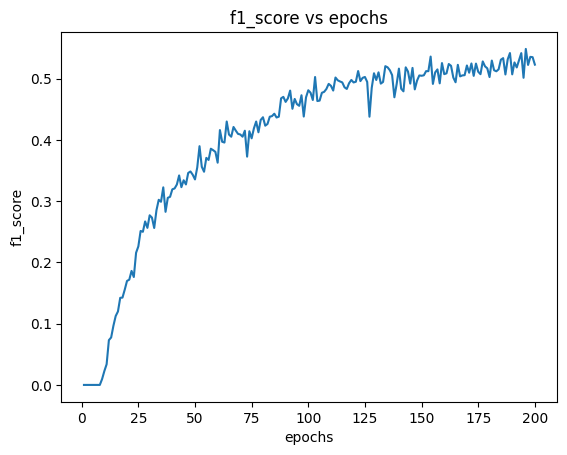

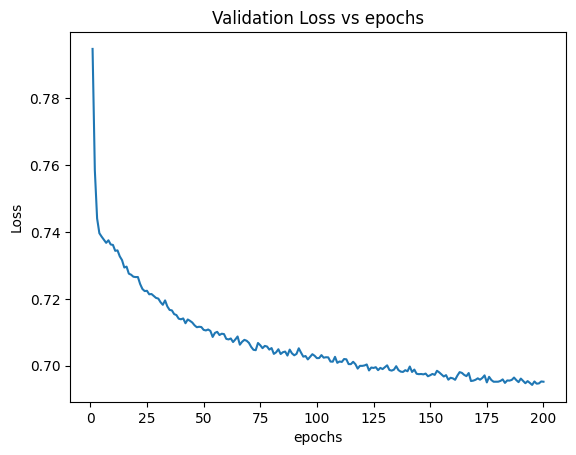

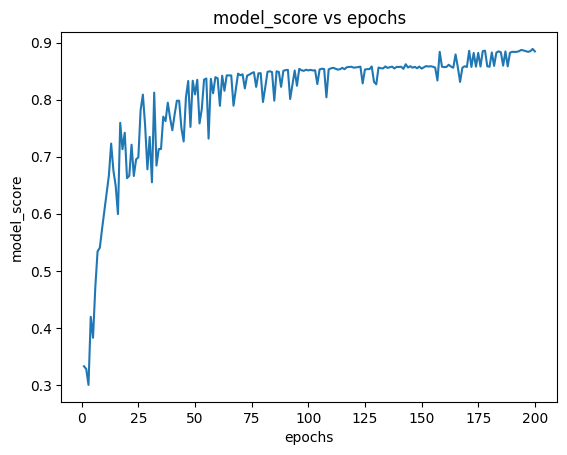

In [8]:
plt.figure(1)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,201), f1_arr)
plt.xlabel("epochs")
plt.ylabel("f1_score")
plt.title('f1_score vs epochs')

plt.figure(2)
#plt.plot(sorted(list(set(roc_epochs))), loss_arr)
plt.plot(range(1,201), loss_arr)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title('Validation Loss vs epochs')

plt.figure(3)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,201), model_arr)
plt.xlabel("epochs")
plt.ylabel("model_score")
plt.title('model_score vs epochs')

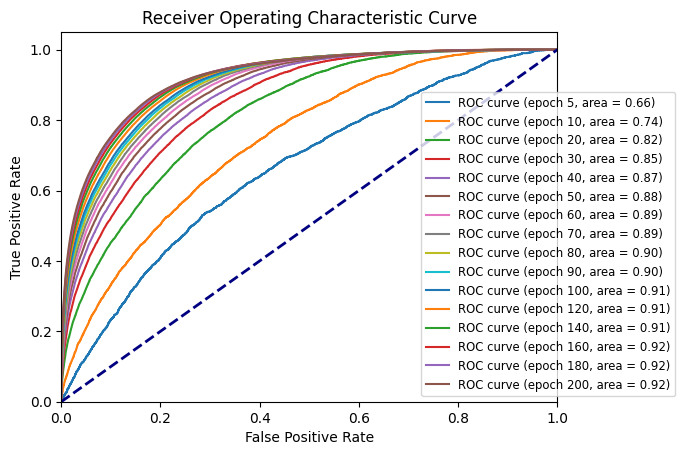

In [7]:
# plot ROC curve
fig2, ax2 = plt.subplots()
for i in range(len(roc_auc)):
    ax2.plot(roc_fpr[i], roc_tpr[i], label=f'ROC curve (epoch {roc_epochs[i]}, area = {roc_auc[i]:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic Curve')
# Set the properties for the legend
legend = ax2.legend(loc='lower right', bbox_to_anchor=(1.25, 0), fontsize='small', framealpha=0.8)